In [947]:
import pandas as pd
import numpy as np 
import pickle
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

In [948]:
df = pd.read_csv("matches/noyes_actual_matches_arrival_new.csv")

In [949]:
df["hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
df["dayofweek"] = pd.to_datetime(df["scheduled_arr"]).dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)


In [950]:
df = pd.get_dummies(df, columns=["direction"], drop_first=True)

In [951]:
base_features = ["hour", "dayofweek", "is_weekend", "direction_Linden"]
X = df[base_features]
y = df["error_min"]


In [952]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(base_features)


In [953]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [954]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [955]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE with polynomial features:", mse)


Test MSE with polynomial features: 6.208235863425329


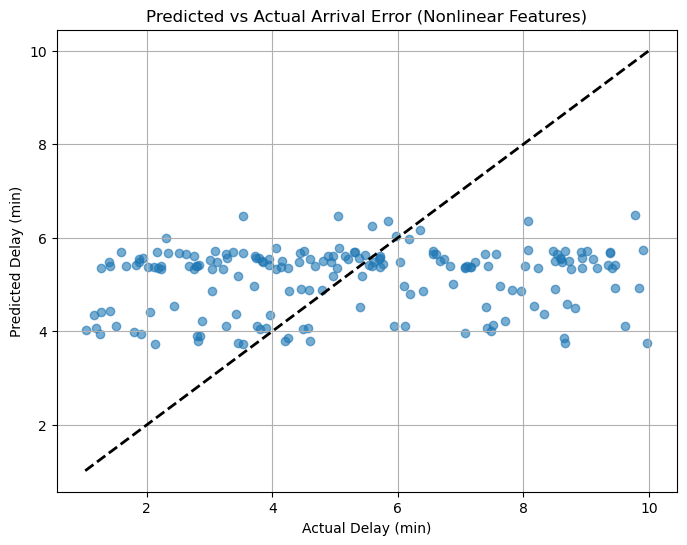

In [956]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Predicted vs Actual Arrival Error (Nonlinear Features)")
plt.grid(True)
plt.show()

In [957]:
coeff_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": model.coef_
}).sort_values("coefficient", key=abs, ascending=False)

coeff_df.head(10)  # Top 10 influential features


feature  coefficient
11                 is_weekend^2    -2.054508
2                    is_weekend    -2.054508
9          dayofweek is_weekend     0.948033
13           direction_Linden^2     0.884868
3              direction_Linden     0.884868
12  is_weekend direction_Linden     0.223921
1                     dayofweek     0.163994
10   dayofweek direction_Linden    -0.130410
6               hour is_weekend    -0.095045
8                   dayofweek^2    -0.054210

In [958]:
# Cleanup poly features
# Remove redundant features
# e.g. is_weekend^2 if is_weekend is binary anyway (0 or 1)
# Remove very small coefficient terms (< 0.05 in magnitude)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
drop_cols = [
    "is_weekend^2",
    "direction_Linden^2",
    "is_weekend direction_Linden"
]
X_poly_df_clean = X_poly_df.drop(columns=drop_cols)

In [959]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_df_clean, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression MSE:", mse_lin)

Linear Regression MSE: 6.215643545209592


In [960]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression MSE:", mse_ridge)
print("Best alpha:", ridge_model.alpha_)

Ridge Regression MSE: 6.187573426263646
Best alpha: 1.0


In [961]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression MSE:", mse_lasso)
print("Best alpha:", lasso_model.alpha_)

Lasso Regression MSE: 6.153151696630566
Best alpha: 0.01


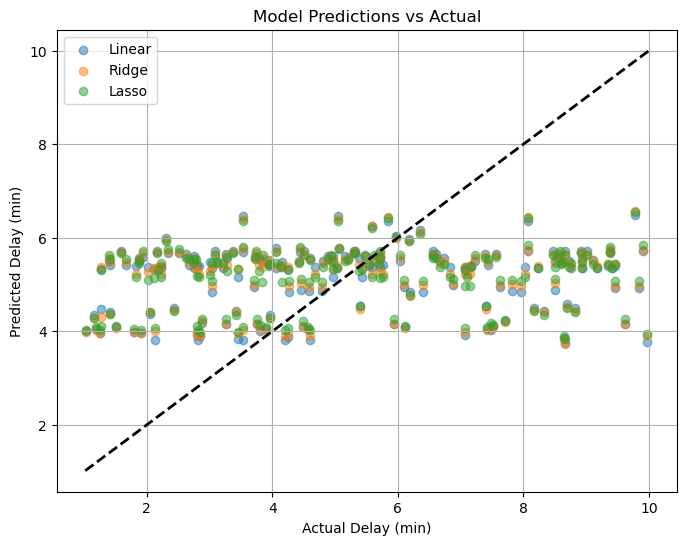

In [962]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear")
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label="Ridge")
plt.scatter(y_test, y_pred_lasso, alpha=0.5, label="Lasso")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [963]:
def show_coefficients(model, label):
    coef_df = pd.DataFrame({
        "feature": X_poly_df_clean.columns,
        "coefficient": model.coef_
    }).sort_values("coefficient", key=abs, ascending=False)
    print(f"\nTop coefficients for {label}:")
    display(coef_df.head(10))

show_coefficients(lin_model, "Linear Regression")
show_coefficients(ridge_model, "Ridge Regression")
show_coefficients(lasso_model, "Lasso Regression")


Top coefficients for Linear Regression:


feature  coefficient
2                   is_weekend    -3.926868
3             direction_Linden     1.713565
9         dayofweek is_weekend     0.939334
1                    dayofweek     0.152912
10  dayofweek direction_Linden    -0.099462
6              hour is_weekend    -0.092192
8                  dayofweek^2    -0.054442
0                         hour    -0.021186
7        hour direction_Linden    -0.021015
5               hour dayofweek     0.015282


Top coefficients for Ridge Regression:


feature  coefficient
3             direction_Linden     1.571747
2                   is_weekend    -1.364561
9         dayofweek is_weekend     0.454302
6              hour is_weekend    -0.110027
10  dayofweek direction_Linden    -0.092438
8                  dayofweek^2    -0.027689
0                         hour    -0.023064
1                    dayofweek     0.022217
5               hour dayofweek     0.016966
7        hour direction_Linden    -0.010992


Top coefficients for Lasso Regression:


feature  coefficient
3             direction_Linden     1.146997
9         dayofweek is_weekend     0.139865
6              hour is_weekend    -0.098238
10  dayofweek direction_Linden    -0.033148
8                  dayofweek^2    -0.012076
5               hour dayofweek     0.010940
7        hour direction_Linden     0.009970
0                         hour    -0.007961
4                       hour^2     0.001588
1                    dayofweek    -0.000000

In [964]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest MSE: 6.2231794664597615


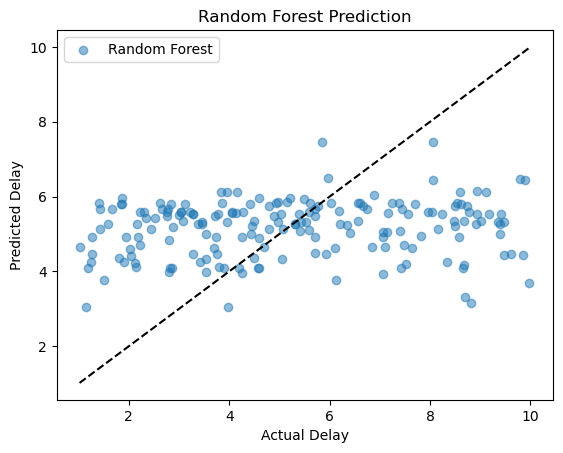

In [965]:
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Random Forest Prediction")
plt.legend()
plt.show()


In [966]:
df["actual_arr"] = pd.to_datetime(df["actual_arr"])
df["first_seen"] = pd.to_datetime(df["first_seen"])

df["minutes_seen_before"] = (df["actual_arr"] - df["first_seen"]).dt.total_seconds() / 60.0
df["was_approaching"] = (df["minutes_seen_before"] < 2).astype(int)  # or use raw value
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)


Random Forest MSE with new features: 5.02464980859275


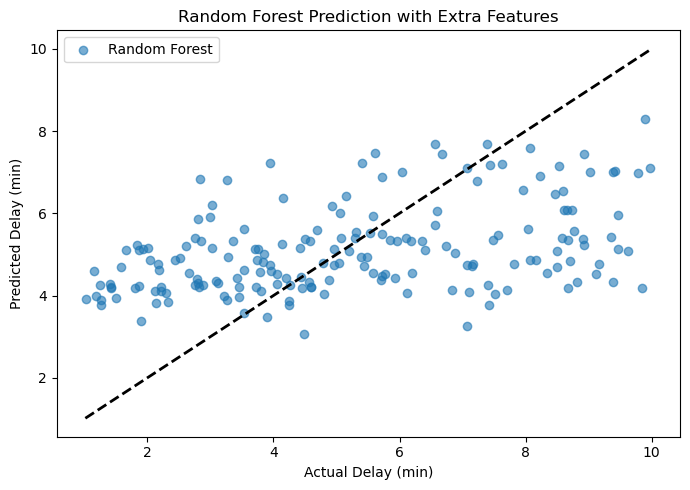

In [967]:
features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before", "was_approaching", "hour_sin", "hour_cos"
]

X = df[features]
y = df["error_min"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Random Forest MSE with new features:", mse)

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, label="Random Forest")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Random Forest Prediction with Extra Features")
plt.legend()
plt.tight_layout()
plt.show()

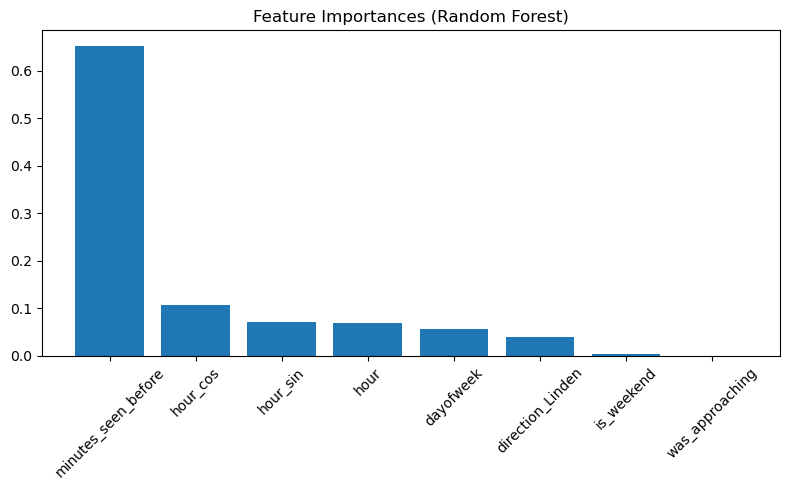

In [968]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=45)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [969]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [970]:
# Predict and calculate MSE
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


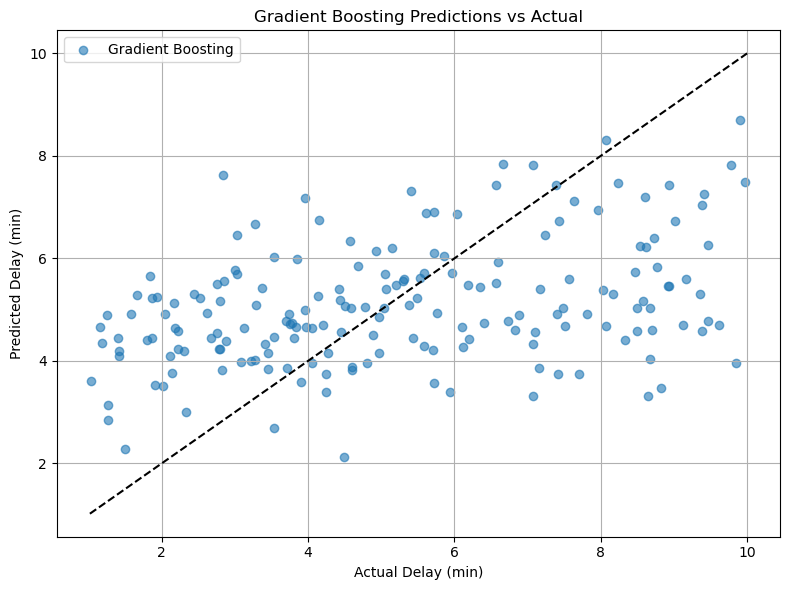

In [971]:
# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Gradient Boosting")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Gradient Boosting Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

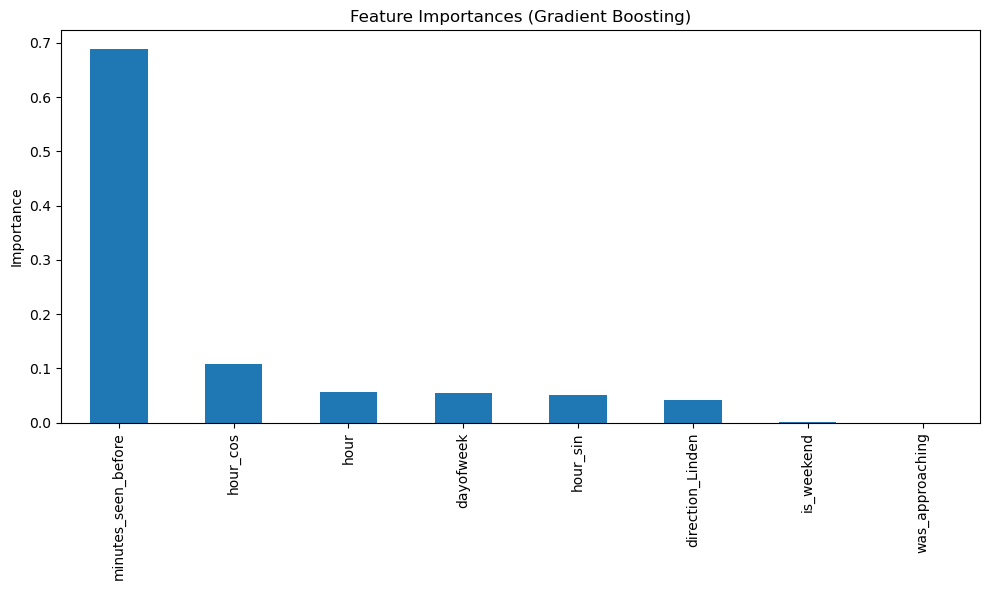

In [972]:
# Feature importances
importances = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind="bar")
plt.title("Feature Importances (Gradient Boosting)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [973]:
# Combine all models for final predictions
df = pd.read_csv("matches/noyes_actual_matches_arrival_new.csv")


In [974]:
import ast

df["hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
df["dayofweek"] = pd.to_datetime(df["scheduled_arr"]).dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["minutes_seen_before"] = (pd.to_datetime(df["actual_arr"]) - pd.to_datetime(df["first_seen"])).dt.total_seconds() / 60.0
df["was_approaching"] = (df["minutes_seen_before"] < 2).astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["direction_Linden"] = (df["direction"] == "Linden").astype(int)

# describe the df
df["opp_arrivals"] = df["opp_dir_live_arrivals"].apply(ast.literal_eval)
df["opp_count"] = df["opp_arrivals"].apply(len)
df["opp_min"] = df["opp_arrivals"].apply(lambda x: min(x) if x else -1)
df["opp_mean"] = df["opp_arrivals"].apply(lambda x: sum(x) / len(x) if x else -1)
df["opp_std"] = df["opp_arrivals"].apply(lambda x: np.std(x) if x else -1)

# Optional: fill NaNs for rows without opposite trains
df.fillna({"opp_min": -1, "opp_mean": -1, "opp_std": -1}, inplace=True)


features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before", "was_approaching",
    "hour_sin", "hour_cos",
    "opp_count", "opp_min", "opp_mean", "opp_std"
]
X = df[features]
y = df["error_min"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [975]:
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5),
    "Lasso": LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {"model": model, "pred": y_pred, "mse": mse}



In [976]:
# For tree-based models
rf = models["RandomForest"]
gb = models["GradientBoost"]
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances_gb = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nRandom Forest Feature Importances:\n", importances_rf)
print("\nGradient Boosting Feature Importances:\n", importances_gb)



Random Forest Feature Importances:
 minutes_seen_before    0.472690
dayofweek              0.097209
opp_min                0.082878
hour_cos               0.074546
opp_mean               0.070104
hour_sin               0.064656
hour                   0.062789
opp_std                0.031331
direction_Linden       0.018409
opp_count              0.018236
is_weekend             0.007152
was_approaching        0.000000
dtype: float64

Gradient Boosting Feature Importances:
 minutes_seen_before    0.532387
opp_mean               0.080751
hour_cos               0.080454
opp_min                0.079201
hour                   0.055294
dayofweek              0.047119
opp_std                0.046369
hour_sin               0.036119
direction_Linden       0.032563
opp_count              0.008786
is_weekend             0.000955
was_approaching        0.000000
dtype: float64


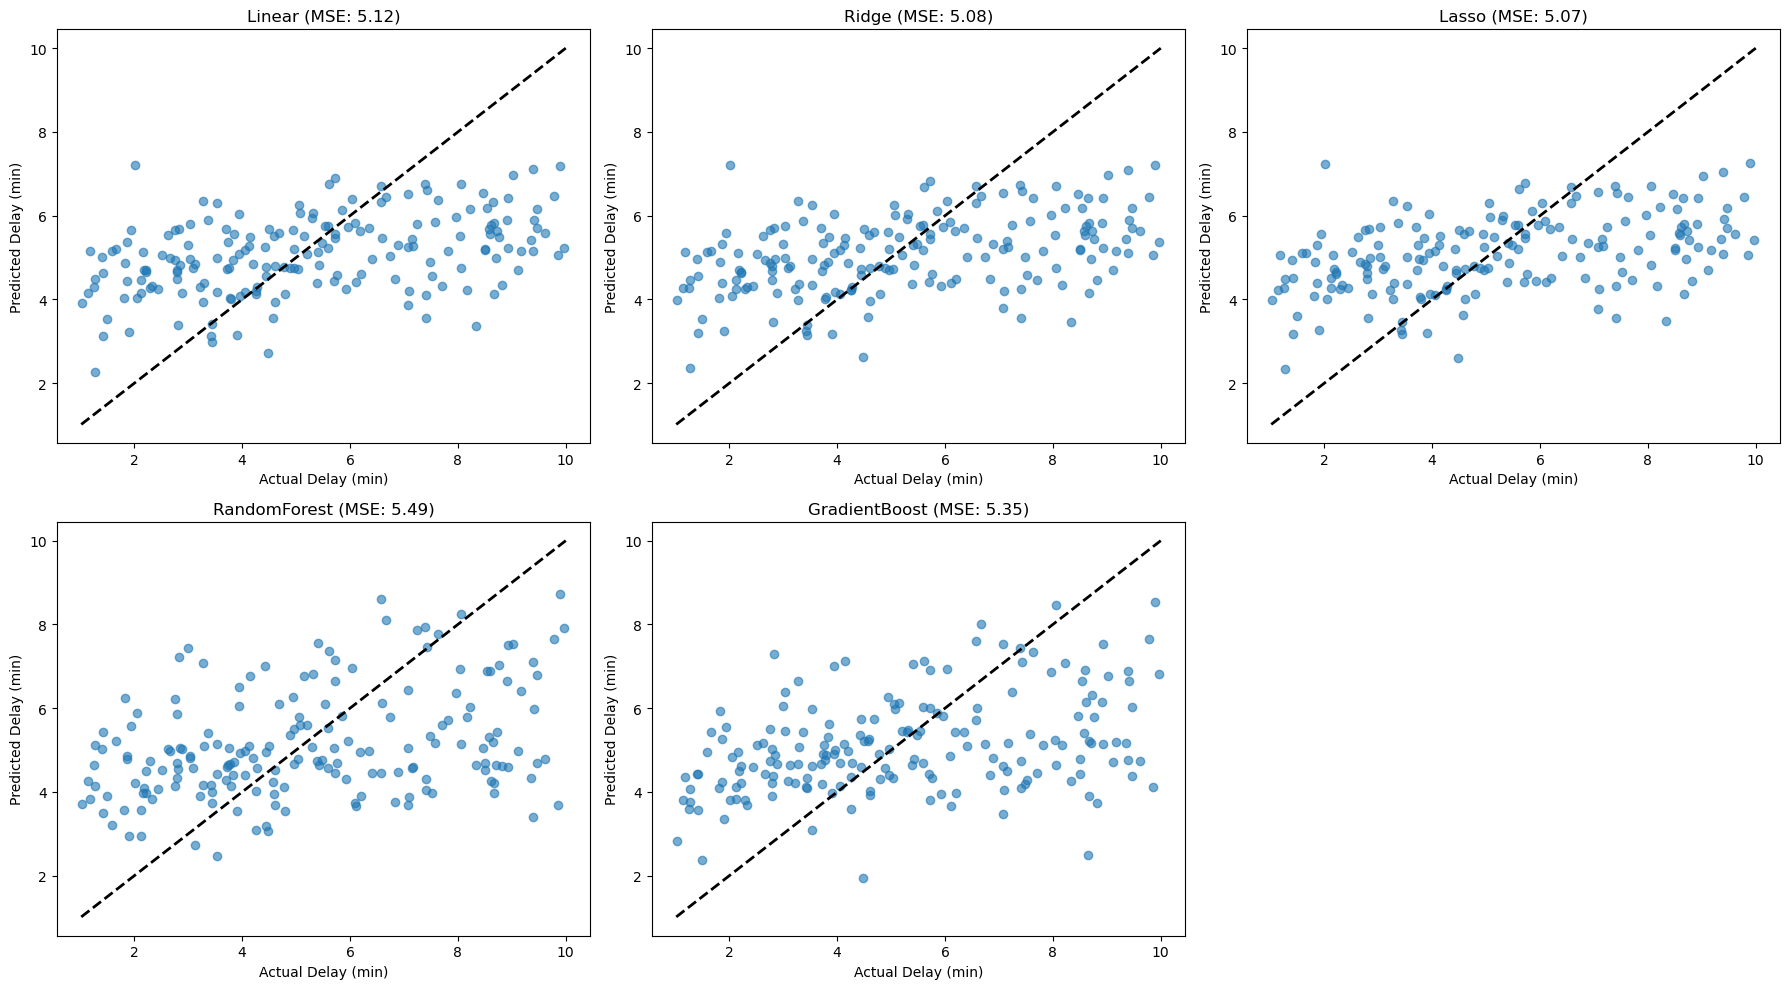

In [977]:
# Plot predicted vs actual for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    ax.scatter(y_test, result["pred"], alpha=0.6)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_title(f"{name} (MSE: {result['mse']:.2f})")
    ax.set_xlabel("Actual Delay (min)")
    ax.set_ylabel("Predicted Delay (min)")

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [978]:
df["opp_min_times_hour"] = df["opp_min"] * df["hour"]
df["opp_mean_diff"] = df["opp_mean"] - df["minutes_seen_before"]

df["delta_opp_min"] = df["opp_min"].diff().fillna(0)

In [979]:
df["opp_count_bin"] = pd.cut(df["opp_count"], bins=[-1, 0, 2, 5, 20], labels=["0", "1-2", "3-5", "6+"])
df = pd.get_dummies(df, columns=["opp_count_bin"], drop_first=True)


In [980]:
def asymmetric_obj(preds, dtrain):
    """
    XGBoost custom objective that penalizes over-prediction more heavily.
    If residual = pred - true:
      • grad = 2*residual  when residual > 0  (over-prediction)
      • grad = residual     when residual <= 0 (under-prediction)
      • hess = 2.0          when residual > 0
      • hess = 1.0          when residual <= 0
    """
    labels   = dtrain.get_label()
    residual = preds - labels

    grad = np.where(residual > 0, 2 * residual, residual)
    hess = np.where(residual > 0, 2.0, 1.0)
    return grad, hess

In [981]:
def train(use_time_split=True, features=features, scale_linear_models=True):
    features = list(set(features))
    X = df[features]
    y = df["error_min"]

    if use_time_split:
        df_sorted = df.sort_values("scheduled_arr")
        cutoff = int(0.8 * len(df_sorted))
        train_df = df_sorted.iloc[:cutoff]
        test_df = df_sorted.iloc[cutoff:]
        X_train = train_df[features]
        y_train = train_df["error_min"]
        X_test = test_df[features]
        y_test = test_df["error_min"]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)


    if X.columns.duplicated().any():
        dupes = X.columns[X.columns.duplicated()].tolist()
        raise ValueError(f"Duplicate column names found: {dupes}")


    # Identify columns in X_train that are constant (nunique==1) or fully NaN
    constant_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
    na_cols       = [col for col in X_train.columns if X_train[col].isna().all()]

    drop_cols = list(set(constant_cols + na_cols))
    if len(drop_cols) > 0:
        X_train.drop(columns=drop_cols, inplace=True)
        X_test.drop(columns=drop_cols, inplace=True)
        features = [f for f in features if f not in drop_cols]
    print(drop_cols)

    ###########################
    # SCALE CONTINUOUS FEATURES FOR LINEAR MODELS
    ###########################
    continuous_cols = [
        "hour", "minutes_seen_before", "opp_min", "opp_mean", "opp_std",
        "opp_min_times_hour", "opp_mean_diff", "delta_opp_min",
        "prev_sched_gap", "next_sched_gap", "trains_next_30min",
        "prev_error_min", "error_diff_1_2"
    ]
    # Keep only those that still exist in features (after dropping constants)
    continuous_cols = [c for c in continuous_cols if c in X_train.columns]

    if scale_linear_models and continuous_cols:
        scaler = StandardScaler().fit(X_train[continuous_cols])
        X_train.loc[:, continuous_cols] = scaler.transform(X_train[continuous_cols])
        X_test.loc[:, continuous_cols] = scaler.transform(X_test[continuous_cols])

    # Initialize models
    models = {
        "Linear": LinearRegression(),
        "Ridge": RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5),
        "Lasso": LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, min_child_samples=1, random_state=42)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"{name} MSE: {mse:.2f}")
        results[name] = {"model": model, "pred": y_pred, "mse": mse}

    # Feature importances (tree-based)
    tree_models = ["RandomForest", "GradientBoost", "XGBoost", "LightGBM"]
    for name in tree_models:
        model = results[name]["model"]
        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print(f"\n{name} Feature Importances:\n", importances.head(5))

    # Plot predicted vs actua
    num_models = len(results)
    cols = 3
    rows = math.ceil(num_models / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()
    
    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx]
        ax.scatter(y_test, result["pred"], alpha=0.6)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        ax.set_title(f"{name} (MSE: {result['mse']:.2f})")
        ax.set_xlabel("Actual Delay (min)")
        ax.set_ylabel("Predicted Delay (min)")
    
    # Remove any extra subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()



In [982]:
df["prev_error_min"] = df.groupby("direction_Linden")["error_min"].shift(1).fillna(0)

features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before",
    "hour_sin", "hour_cos",
    "opp_count", "opp_min", "opp_mean", "opp_std",
    "opp_min_times_hour", "opp_mean_diff", "delta_opp_min",
    "prev_error_min"
]

[]
Linear MSE: 6.79
Ridge MSE: 6.76
Lasso MSE: 6.75
RandomForest MSE: 7.45
GradientBoost MSE: 7.30
XGBoost MSE: 8.60
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1400
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 15
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 8.28

RandomForest Feature Importances:
 opp_mean_diff          0.203991
minutes_seen_before    0.200985
prev_error_min         0.167303
delta_opp_min          0.078561
opp_min_times_hour     0.068677
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff          0.253818
minutes_seen_before    0.236053
prev_error_min         0.155196
delta_opp_min          0.070746
opp_min_times_hour     0.063777
dtype: float64

XGBoost Feature Importances:
 hour                0.217763
opp_mean_diff       0.107862
hour_sin    

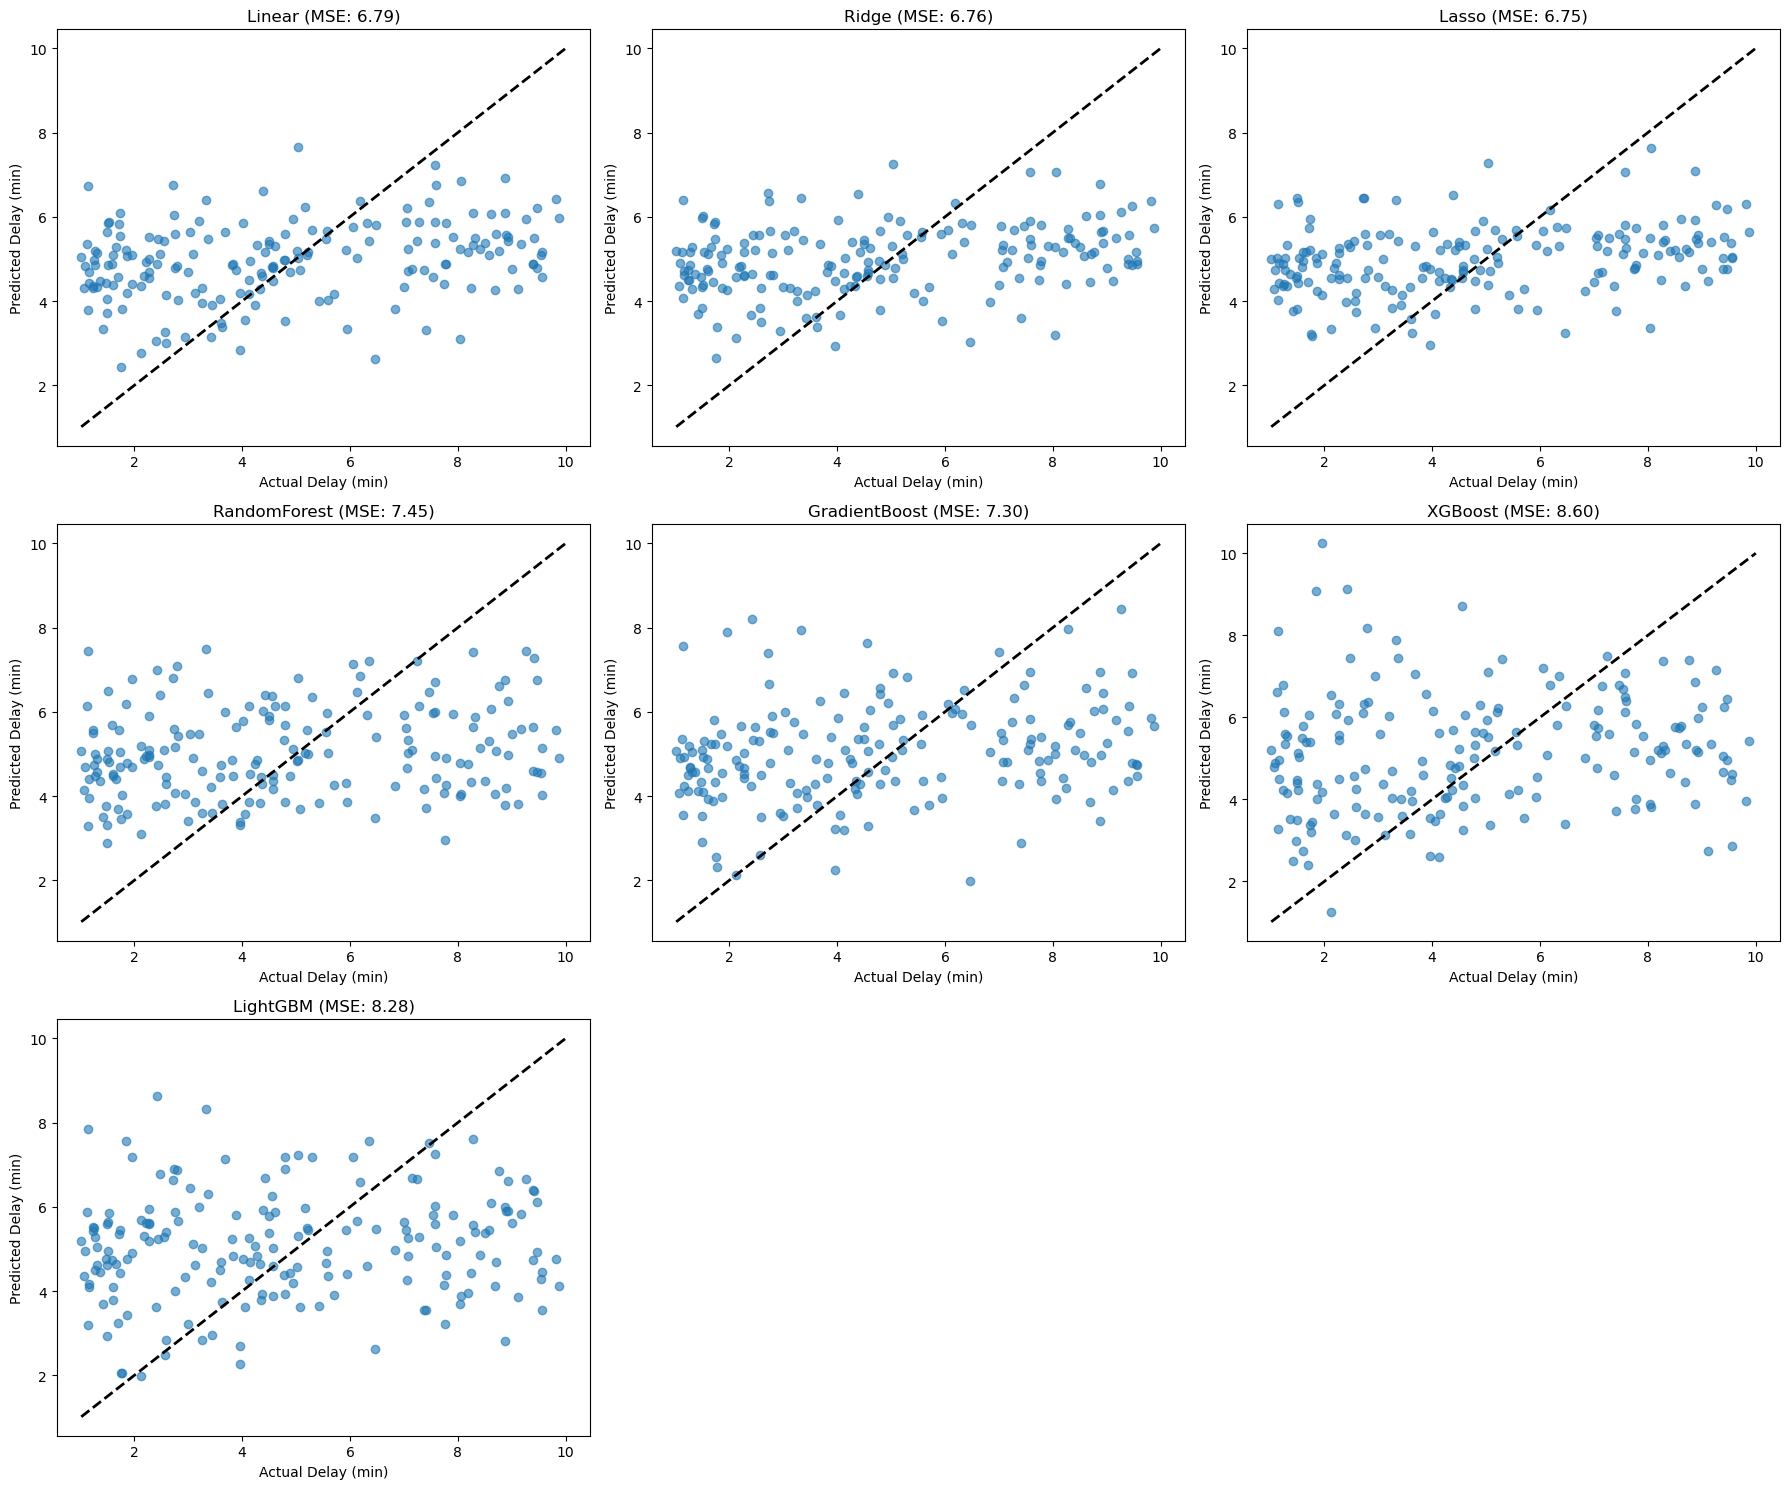

In [983]:
train(features=features, scale_linear_models=True)

[]
Linear MSE: 6.93
Ridge MSE: 6.89
Lasso MSE: 6.82
RandomForest MSE: 7.24
GradientBoost MSE: 7.46
XGBoost MSE: 8.00
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 16
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.76

RandomForest Feature Importances:
 opp_mean_diff          0.187645
minutes_seen_before    0.181370
prev_error_min         0.142063
next_sched_gap         0.119024
delta_opp_min          0.068447
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff          0.231203
minutes_seen_before    0.201030
prev_error_min         0.124157
next_sched_gap         0.113345
delta_opp_min          0.073340
dtype: float64

XGBoost Feature Importances:
 hour                0.151135
direction_Linden    0.124460
opp_mean_dif

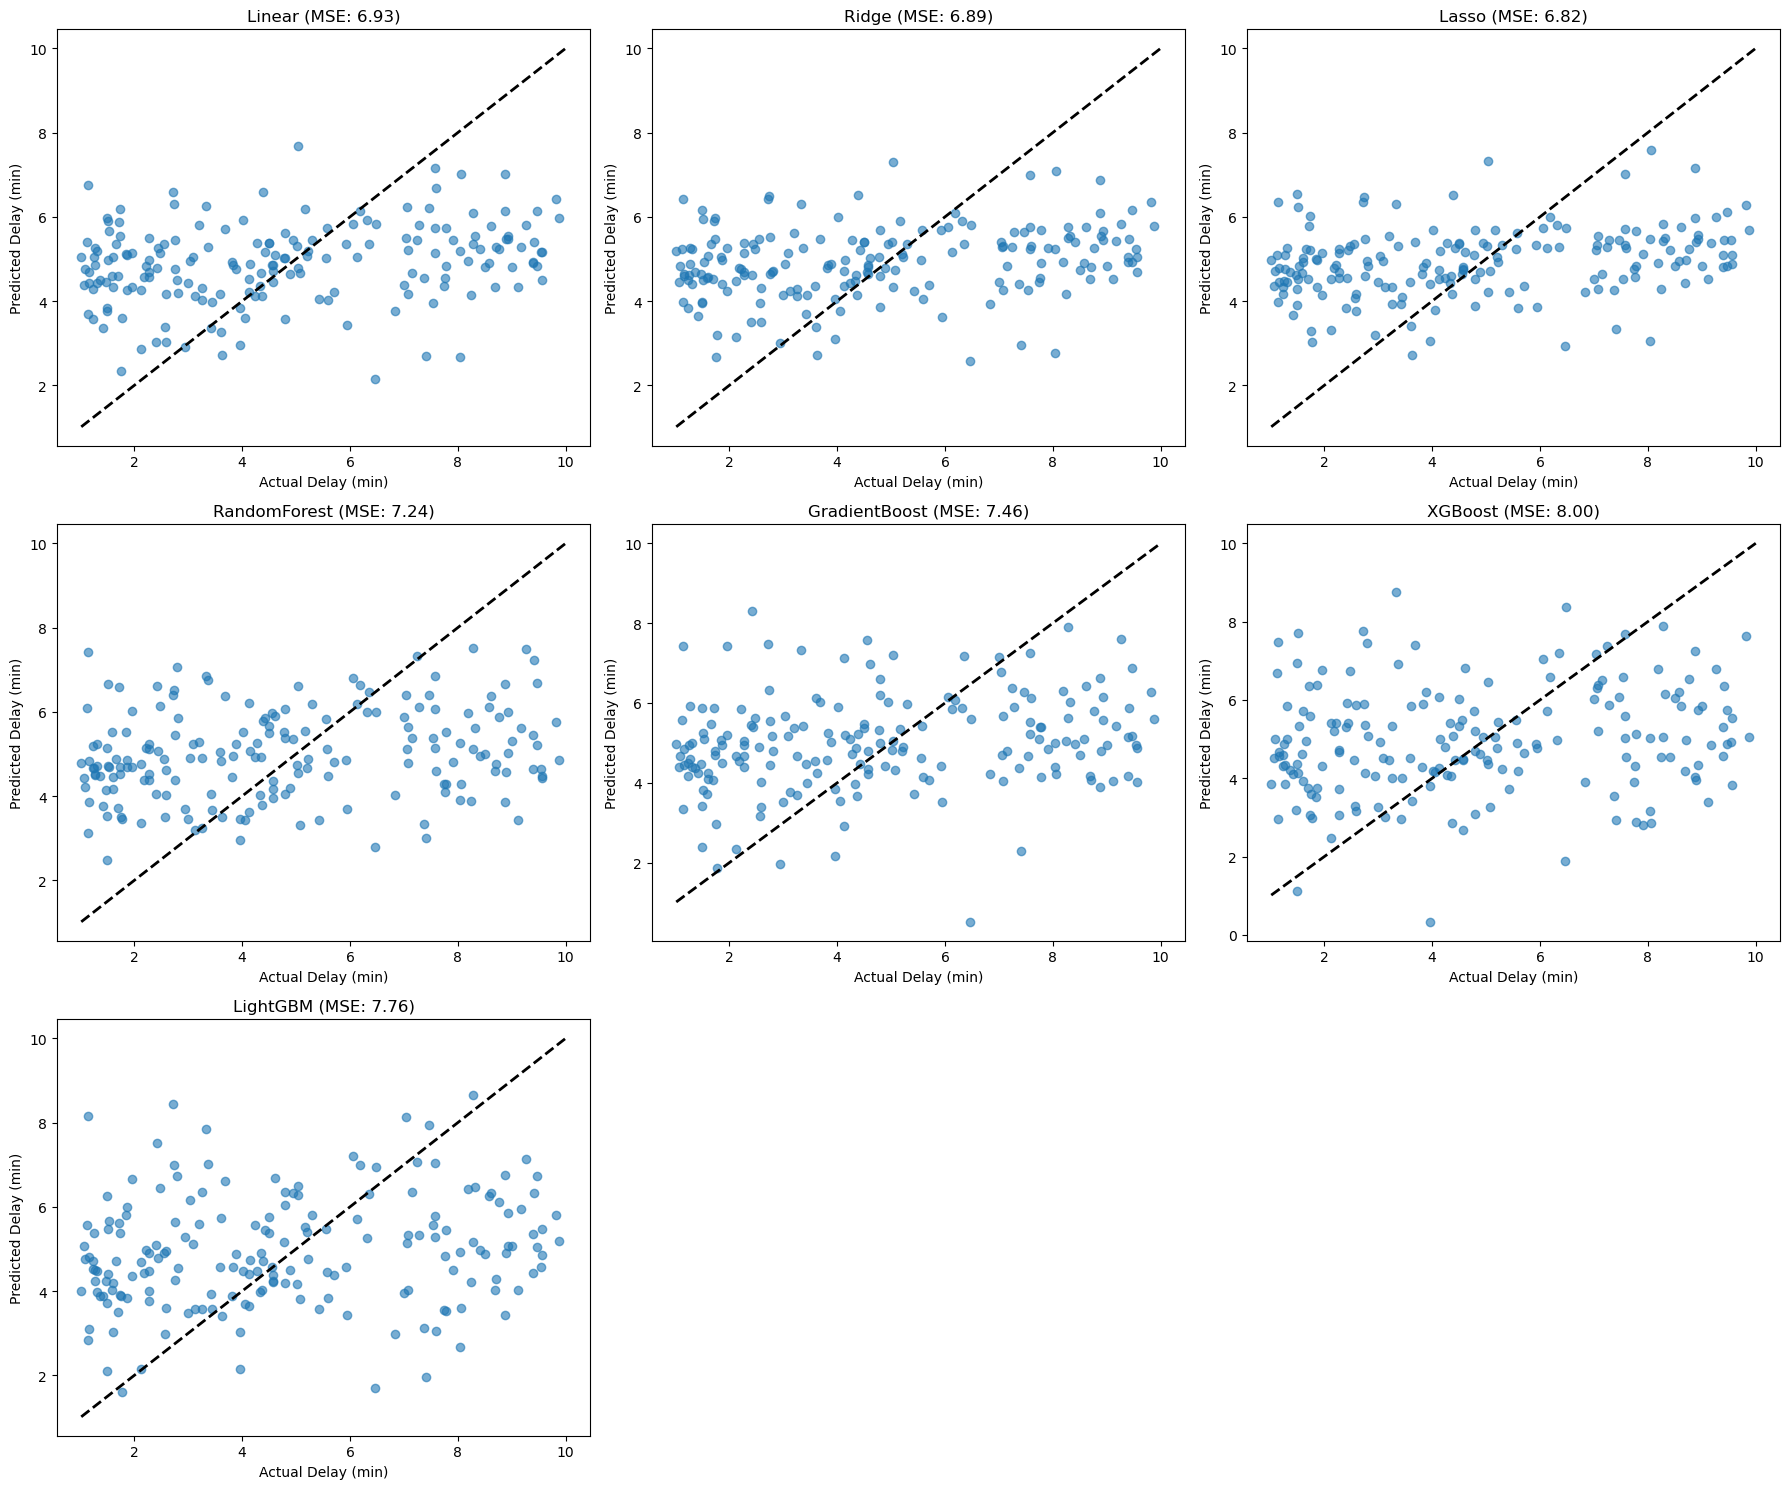

In [984]:
# the scheduled_arr is a string use it as a timestamp
df["scheduled_arr"] = pd.to_datetime(df["scheduled_arr"])
df["next_sched_gap"] = df.groupby("direction_Linden")["scheduled_arr"].shift(-1) - df["scheduled_arr"]
df["next_sched_gap"] = df["next_sched_gap"].dt.total_seconds() / 60.0
df["next_sched_gap"].fillna(0, inplace=True)
features.append("next_sched_gap")
train(features=features, scale_linear_models=True)

In [985]:
df["prev_error_times_seen"] = df["prev_error_min"] * df["minutes_seen_before"]

In [986]:
df["scheduled_hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
rolling_avg = df.groupby("scheduled_hour")["error_min"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df["hourly_error_trend"] = (
    df.groupby("scheduled_hour")["error_min"]
      .expanding()
      .apply(lambda x: x.iloc[:-1].mean() if len(x) > 1 else np.nan)
      .reset_index(level=0, drop=True)
).fillna(0)


In [987]:
df["is_rush"] = ((df["hour"].between(7, 9)) | (df["hour"].between(16, 18))).astype(int)
df["weekday_rush"] = (df["is_rush"] & (df["dayofweek"] < 5)).astype(int)


In [988]:
features.append("prev_error_times_seen")
features.append("hourly_error_trend")
features.append("is_rush")
features.append("weekday_rush")

[]
Linear MSE: 6.99
Ridge MSE: 6.91
Lasso MSE: 6.86
RandomForest MSE: 7.39
GradientBoost MSE: 7.40
XGBoost MSE: 8.07
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 20
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 8.16

RandomForest Feature Importances:
 opp_mean_diff            0.168344
minutes_seen_before      0.151390
prev_error_times_seen    0.101396
hourly_error_trend       0.097987
next_sched_gap           0.094731
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.240850
minutes_seen_before      0.150965
next_sched_gap           0.097619
prev_error_times_seen    0.095654
prev_error_min           0.079826
dtype: float64

XGBoost Feature Importances:
 weekday_rush           0.121591
opp_mean_diff     

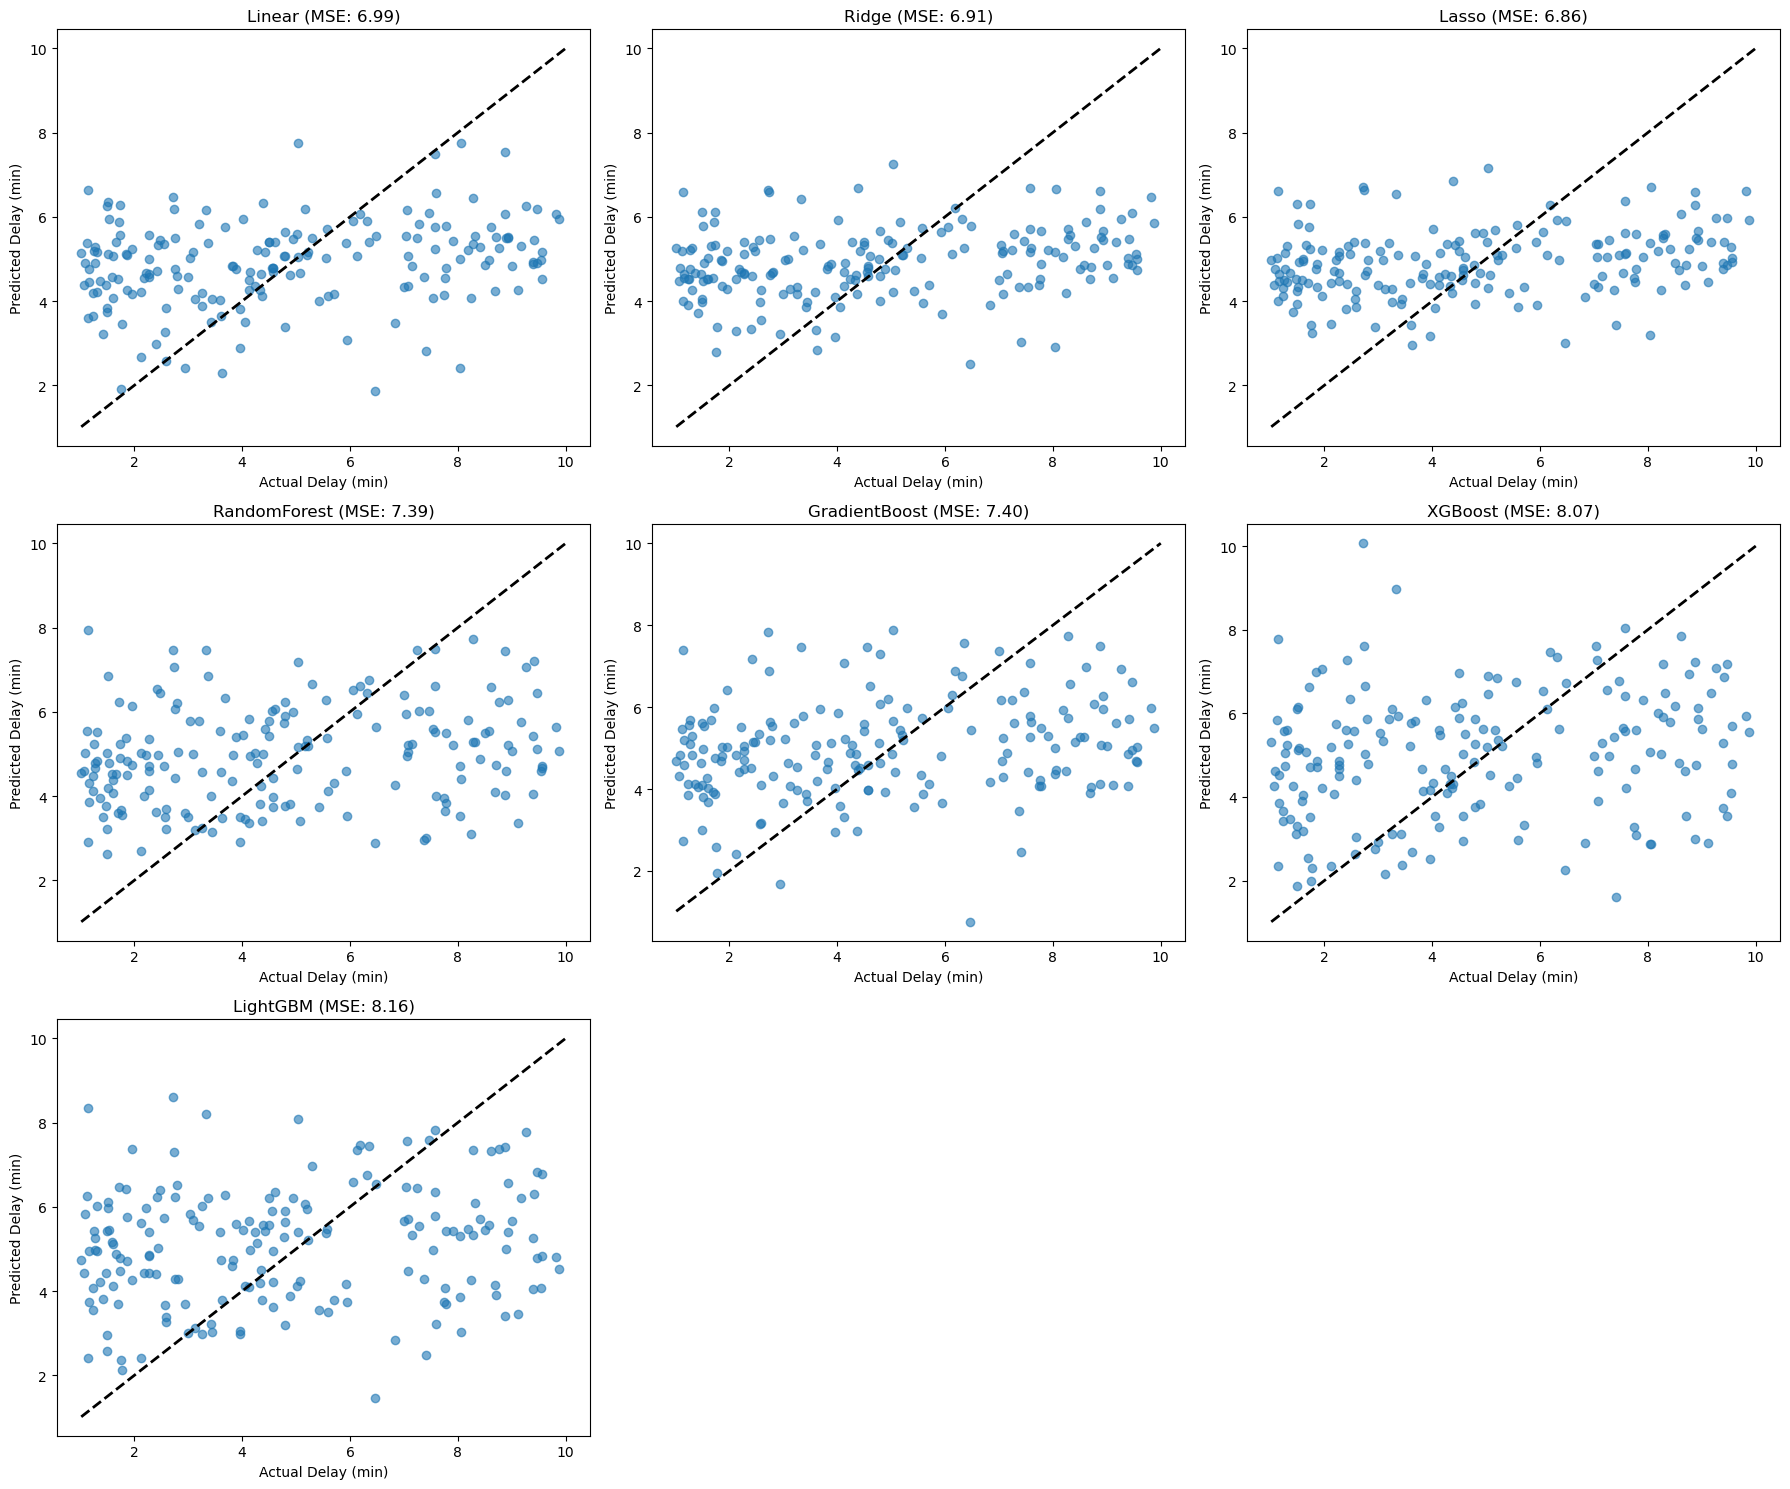

In [989]:
train(features=features, scale_linear_models=True)

[]
Linear MSE: 6.86
Ridge MSE: 6.79
Lasso MSE: 6.75
RandomForest MSE: 7.13
GradientBoost MSE: 7.57
XGBoost MSE: 8.69
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 21
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 8.01

RandomForest Feature Importances:
 opp_mean_diff            0.152598
minutes_seen_before      0.142557
hourly_error_std         0.139274
prev_error_times_seen    0.089836
hourly_error_trend       0.088751
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.184930
minutes_seen_before      0.182776
hourly_error_std         0.113686
prev_error_times_seen    0.092858
hourly_error_trend       0.081976
dtype: float64

XGBoost Feature Importances:
 opp_mean_diff          0.138167
weekday_rush      

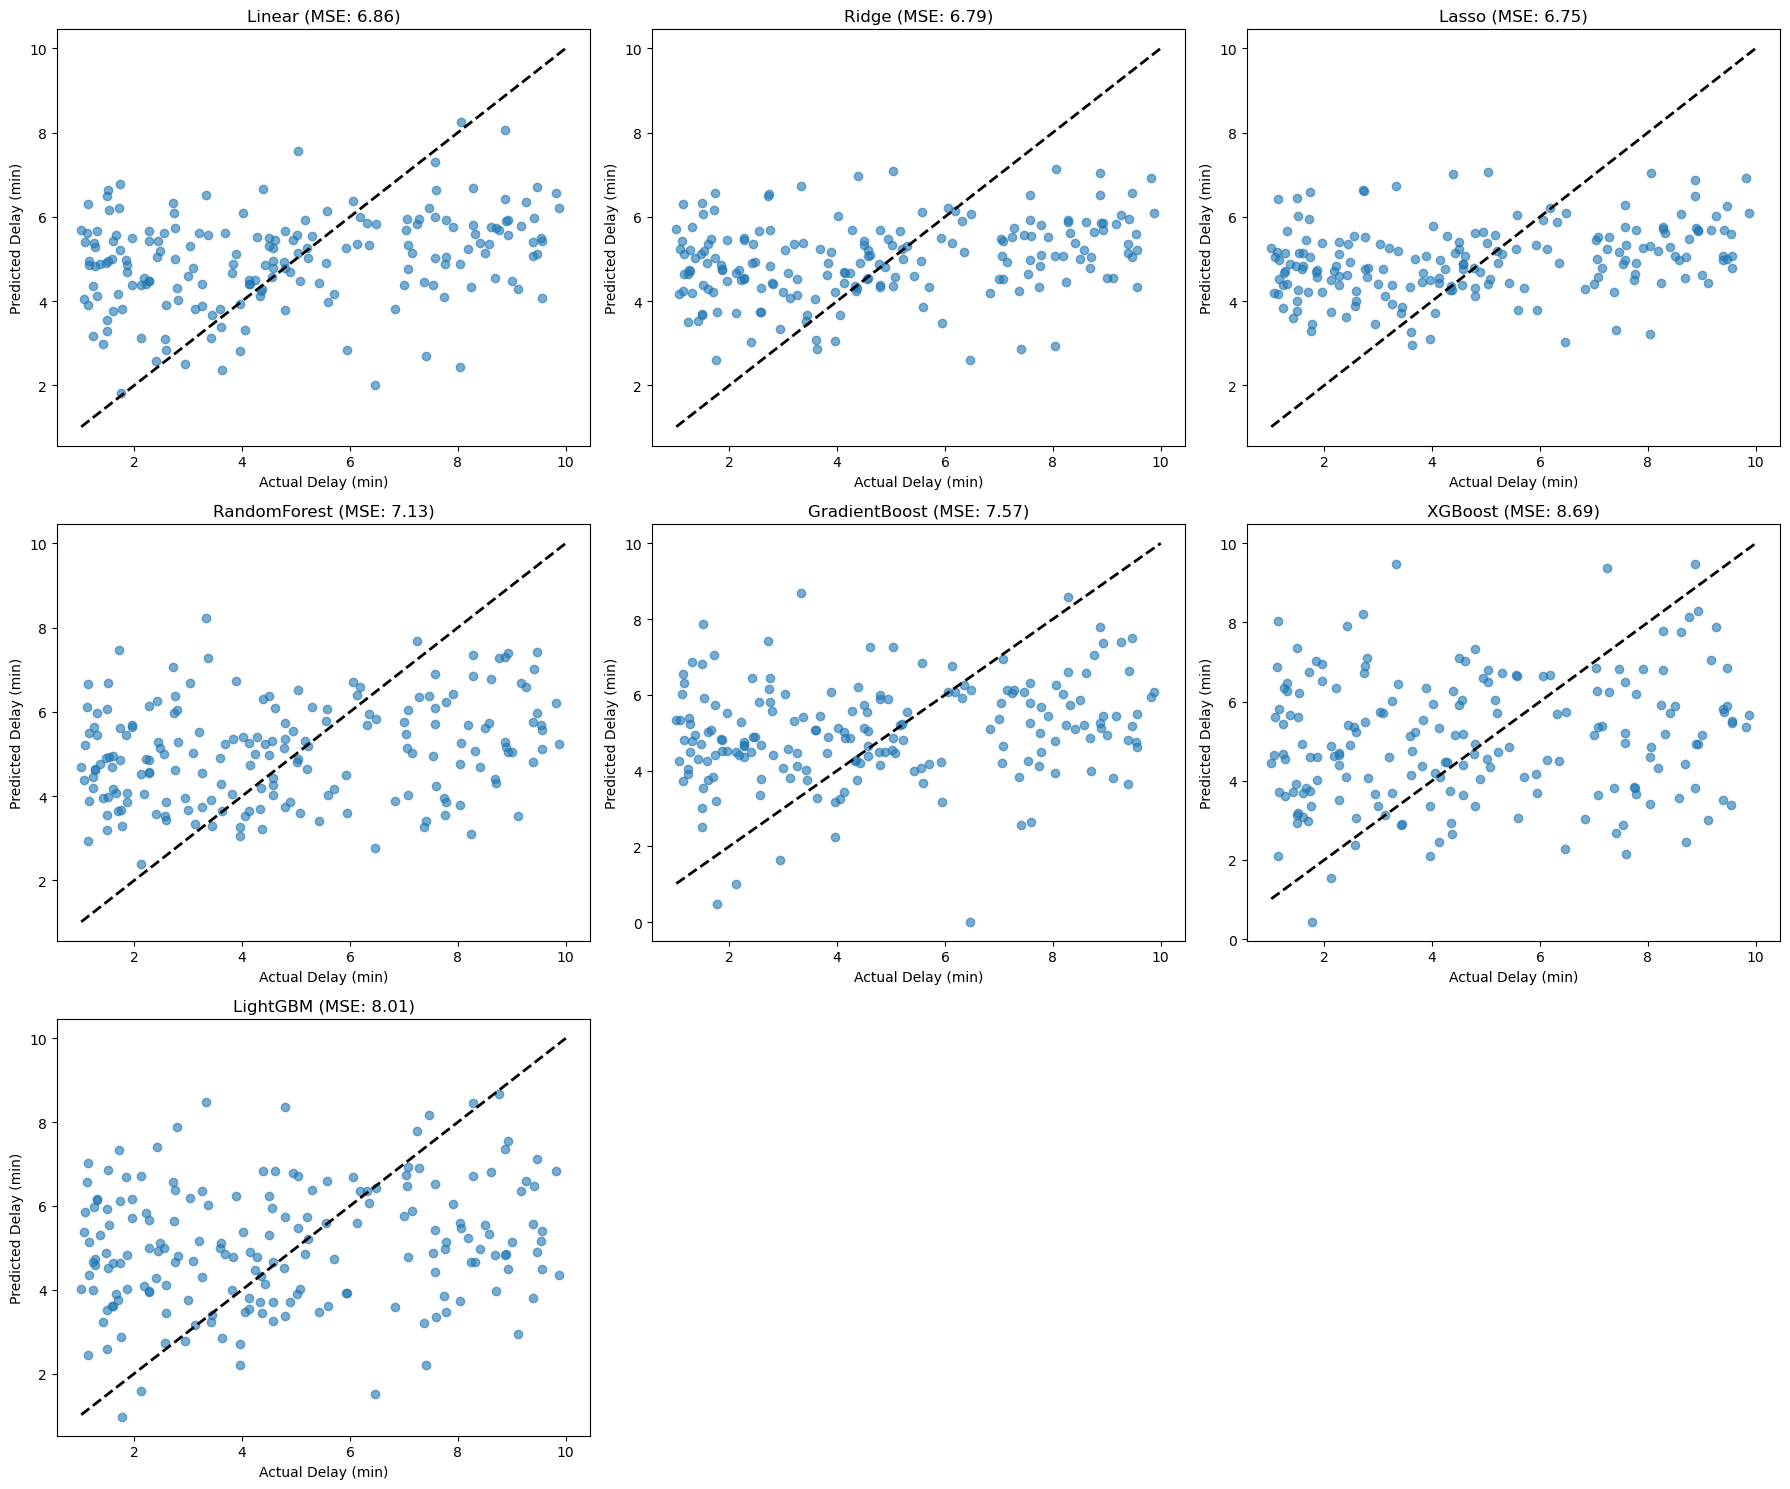

In [990]:
df["hourly_error_std"] = (
    df.groupby("hour")["error_min"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0.0))
)# remove hourly_error_trend and hourly_error_std if they are not useful
features.append("hourly_error_std")

# m

train(features=features, scale_linear_models=True)


In [991]:
df["prev_scheduled_gap"] = df.groupby("direction")["scheduled_arr"].diff().dt.total_seconds() / 60
#make sure to fill NaN values
df["prev_scheduled_gap"].fillna(0, inplace=True)

[]
Linear MSE: 6.88
Ridge MSE: 6.82
Lasso MSE: 6.78
RandomForest MSE: 7.21
GradientBoost MSE: 7.56
XGBoost MSE: 8.05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 22
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.38

RandomForest Feature Importances:
 opp_mean_diff            0.148594
minutes_seen_before      0.136834
hourly_error_std         0.129347
prev_error_times_seen    0.084526
hourly_error_trend       0.082570
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.183658
minutes_seen_before      0.166629
hourly_error_std         0.113417
prev_error_times_seen    0.084866
hourly_error_trend       0.080526
dtype: float64

XGBoost Feature Importances:
 opp_count              0.176047
opp_mean_diff     

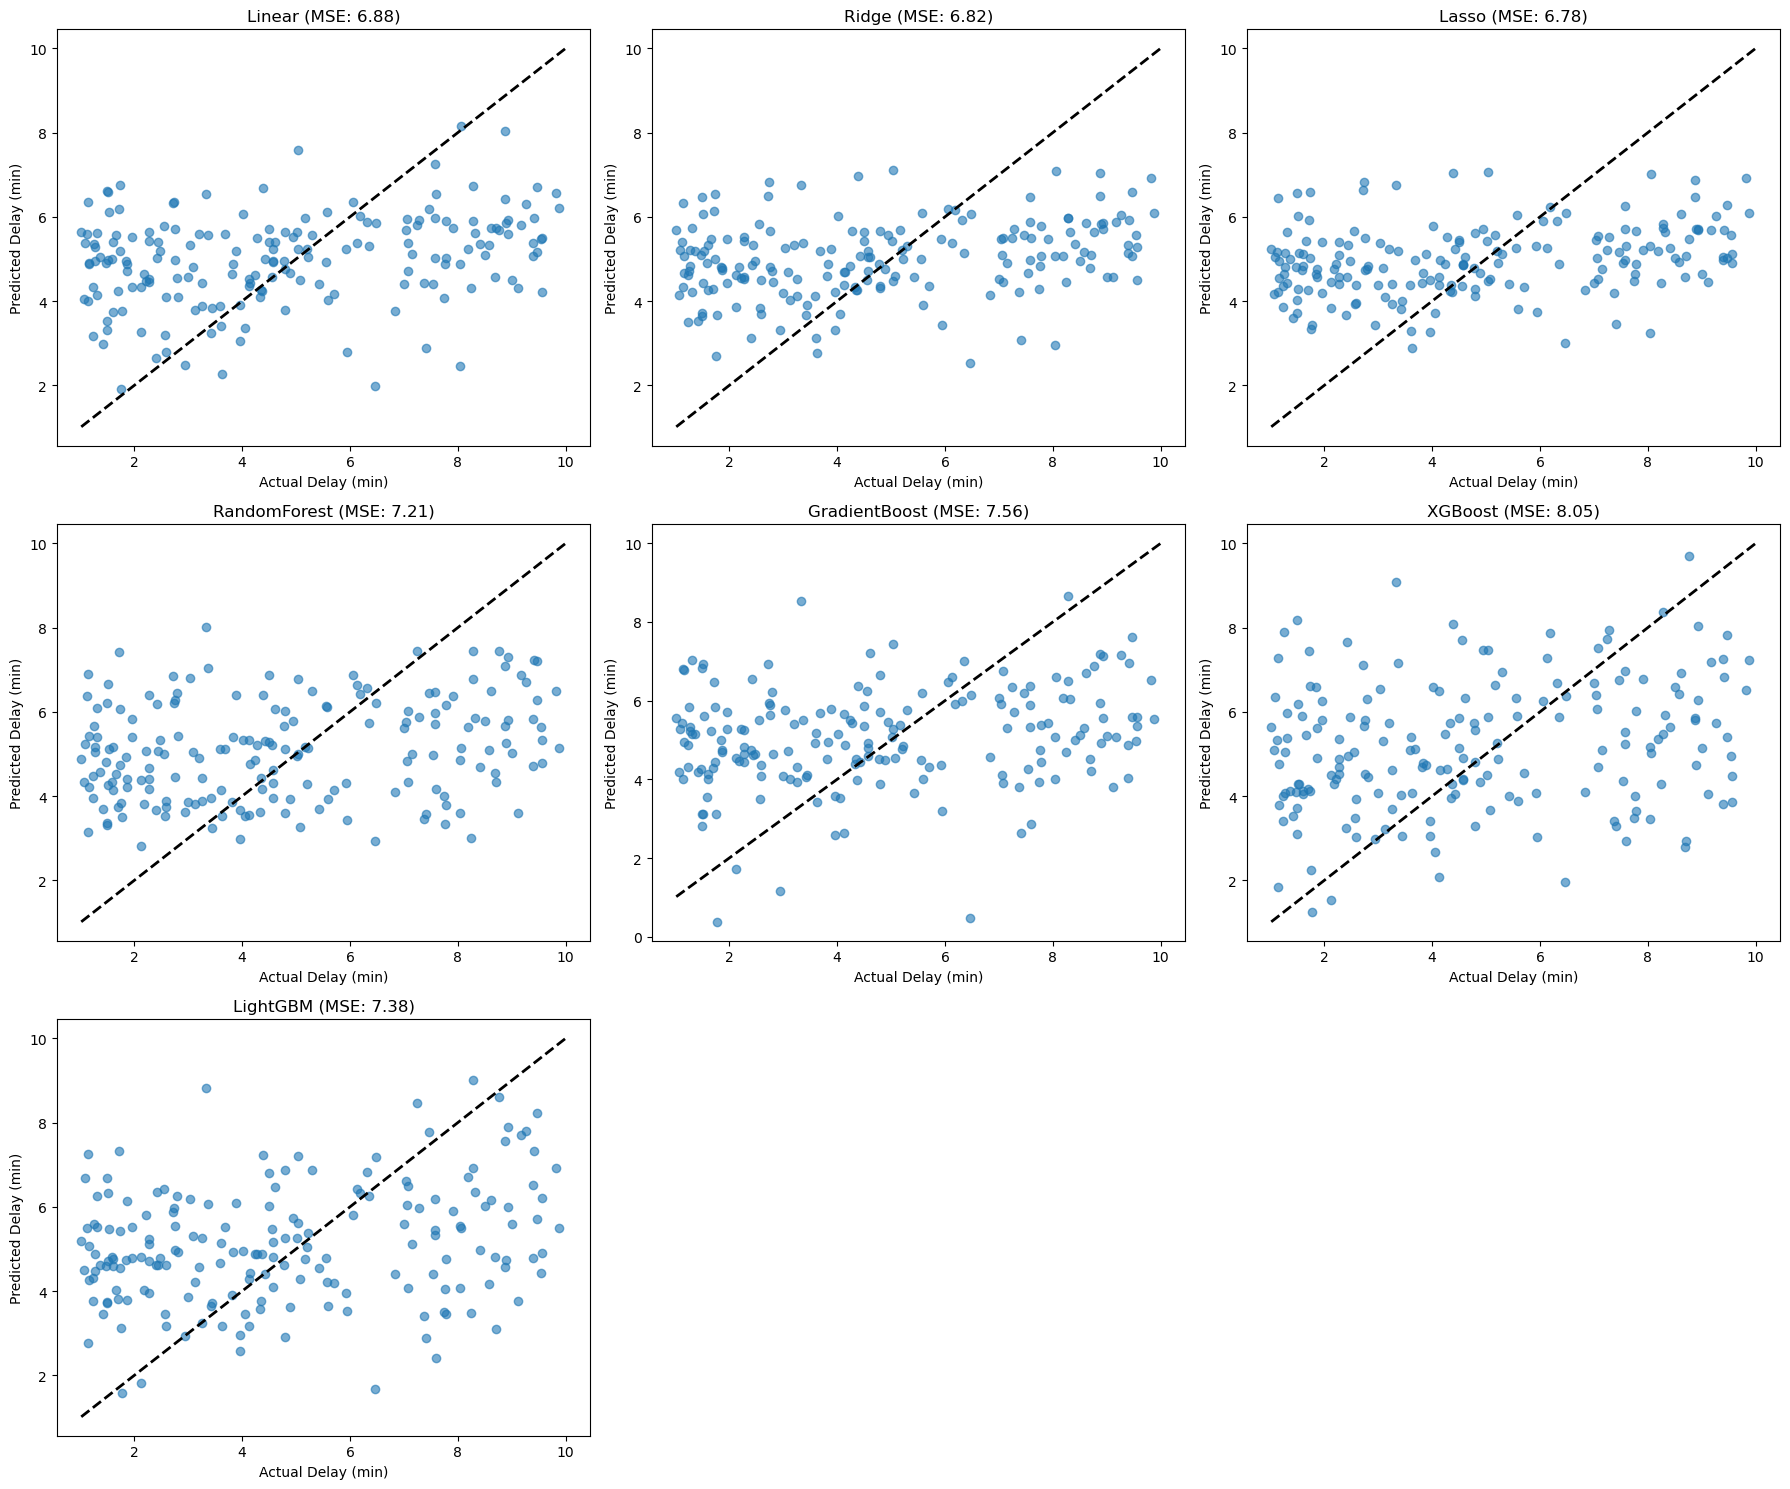

In [992]:
features.append("prev_scheduled_gap")
train(features=features, scale_linear_models=True)

In [993]:
df["is_peak_morning"] = df["hour"].between(7, 9).astype(int)
df["is_peak_evening"] = df["hour"].between(16, 18).astype(int)


In [994]:
features.append("is_peak_morning")
features.append("is_peak_evening")

[]
Linear MSE: 6.96
Ridge MSE: 6.84
Lasso MSE: 6.78
RandomForest MSE: 7.11
GradientBoost MSE: 7.67
XGBoost MSE: 7.95
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 24
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.54

RandomForest Feature Importances:
 opp_mean_diff            0.147150
minutes_seen_before      0.136067
hourly_error_std         0.129995
prev_error_times_seen    0.085569
hourly_error_trend       0.082014
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.181231
minutes_seen_before      0.170221
hourly_error_std         0.118405
prev_error_times_seen    0.086148
hourly_error_trend       0.079829
dtype: float64

XGBoost Feature Importances:
 opp_mean_diff          0.144998
opp_count         

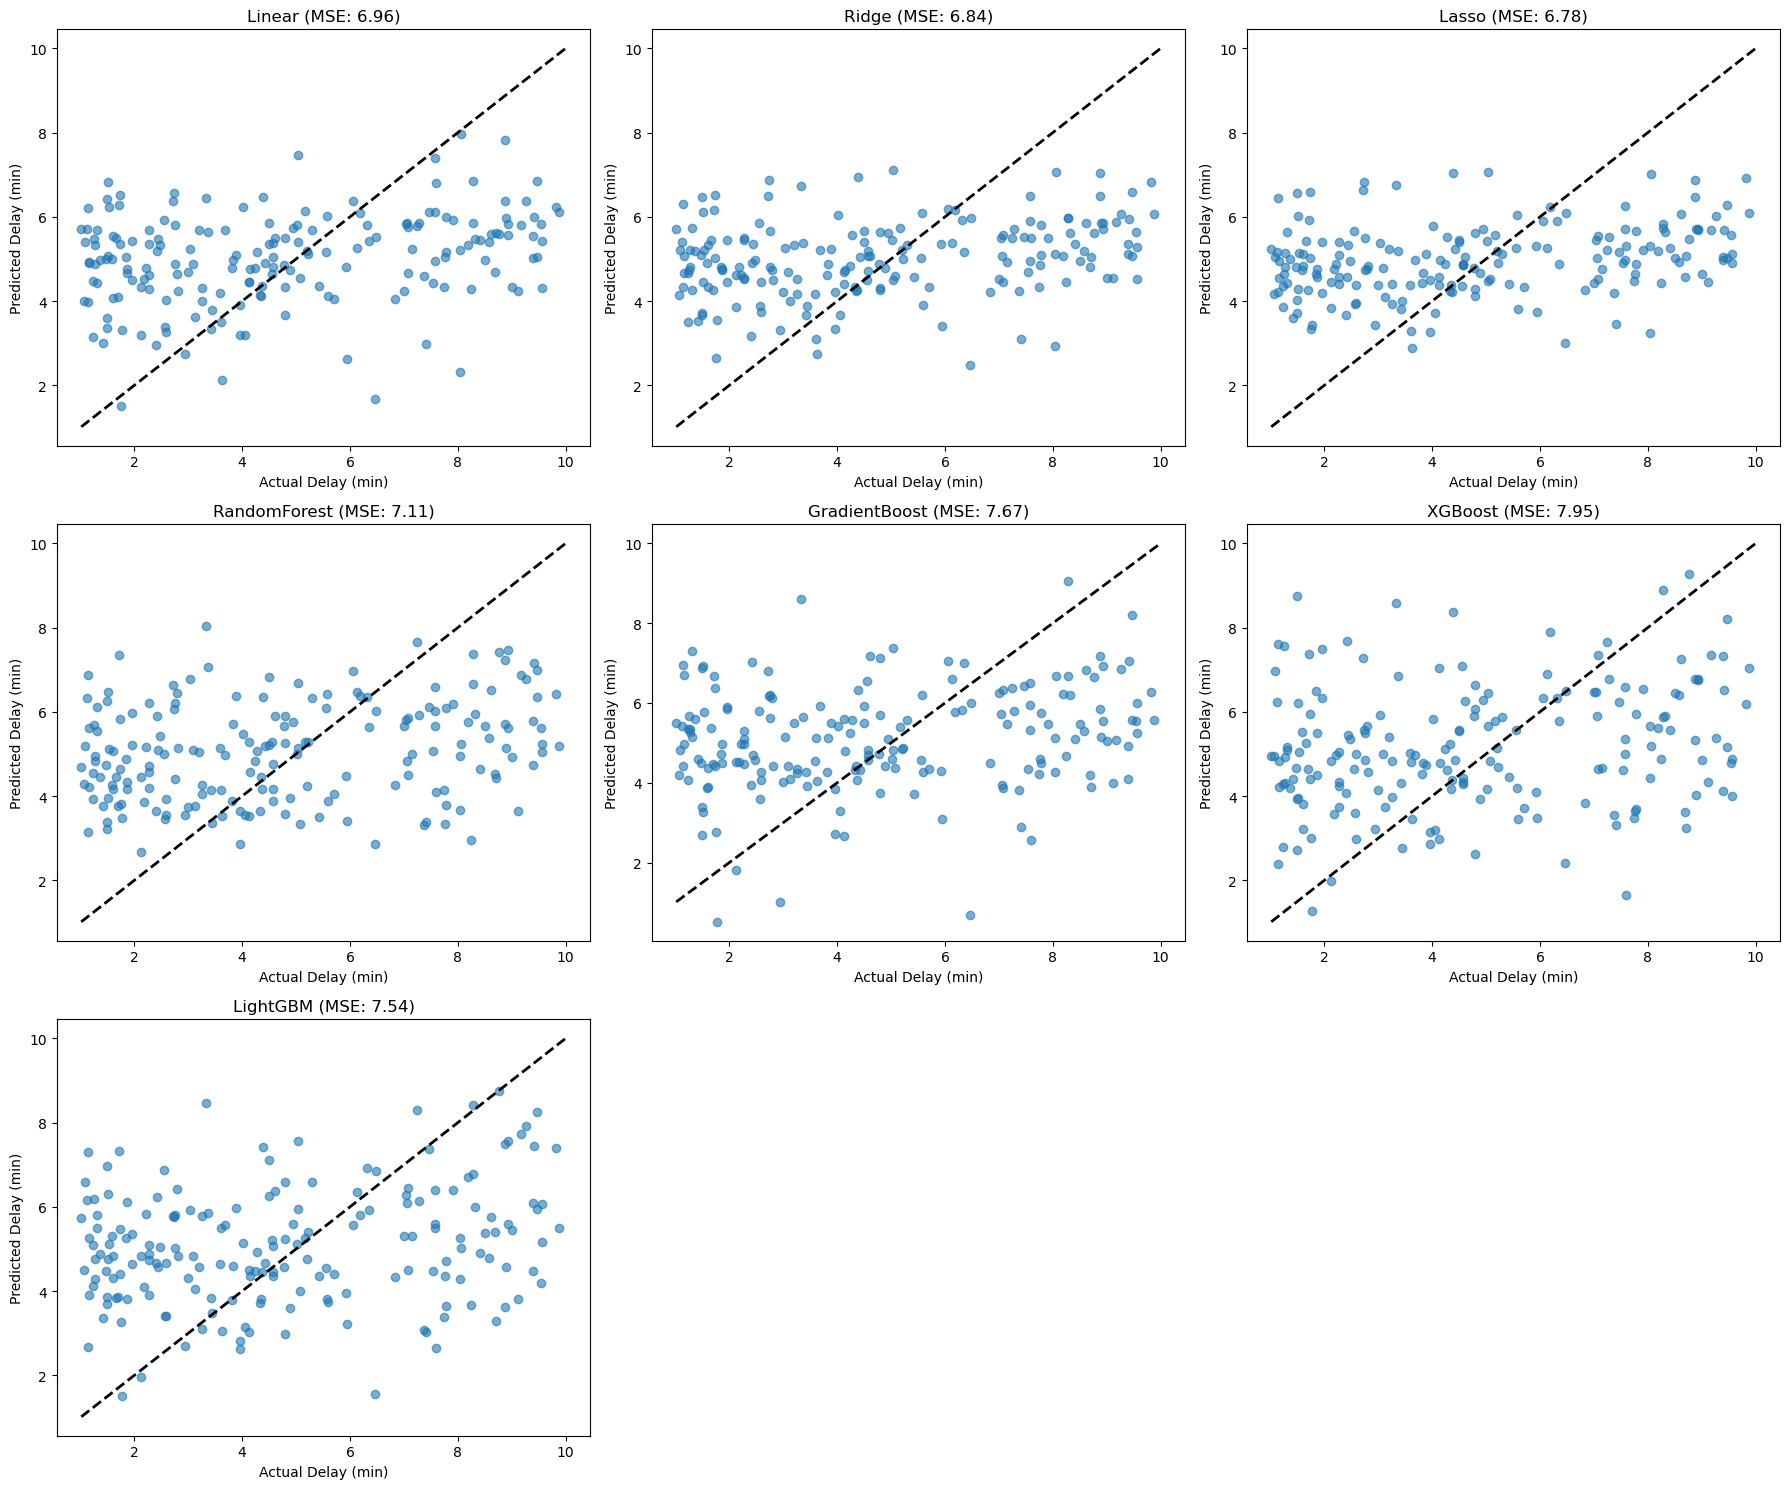

In [995]:
train(features=features, scale_linear_models=True)

In [996]:
df["error_trend_linden"] = df[df["direction_Linden"] == 1].groupby("hour")["error_min"].transform("mean")
df["error_trend_howard"] = df[df["direction_Linden"] == 0].groupby("hour")["error_min"].transform("mean")

# make sure no NaN values
df["error_trend_linden"].fillna(0, inplace=True)
df["error_trend_howard"].fillna(0, inplace=True)

In [997]:
features.append("error_trend_linden")
features.append("error_trend_howard")

In [998]:
df["dir_error_trend"] = df.apply(lambda r: r["error_trend_linden"] if r["direction_Linden"] else r["error_trend_howard"], axis=1)

# make sure no NaN values
df["dir_error_trend"].fillna(0, inplace=True)

In [999]:
features.append("dir_error_trend")

[]
Linear MSE: 6.52
Ridge MSE: 6.47
Lasso MSE: 6.47
RandomForest MSE: 6.87
GradientBoost MSE: 7.04
XGBoost MSE: 7.71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2699
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 27
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.73

RandomForest Feature Importances:
 opp_mean_diff            0.142202
minutes_seen_before      0.132783
hourly_error_std         0.124666
prev_error_times_seen    0.077401
hourly_error_trend       0.071806
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.161943
minutes_seen_before      0.157465
hourly_error_std         0.103075
dir_error_trend          0.076418
prev_error_times_seen    0.073118
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.158362
weekday_rush      

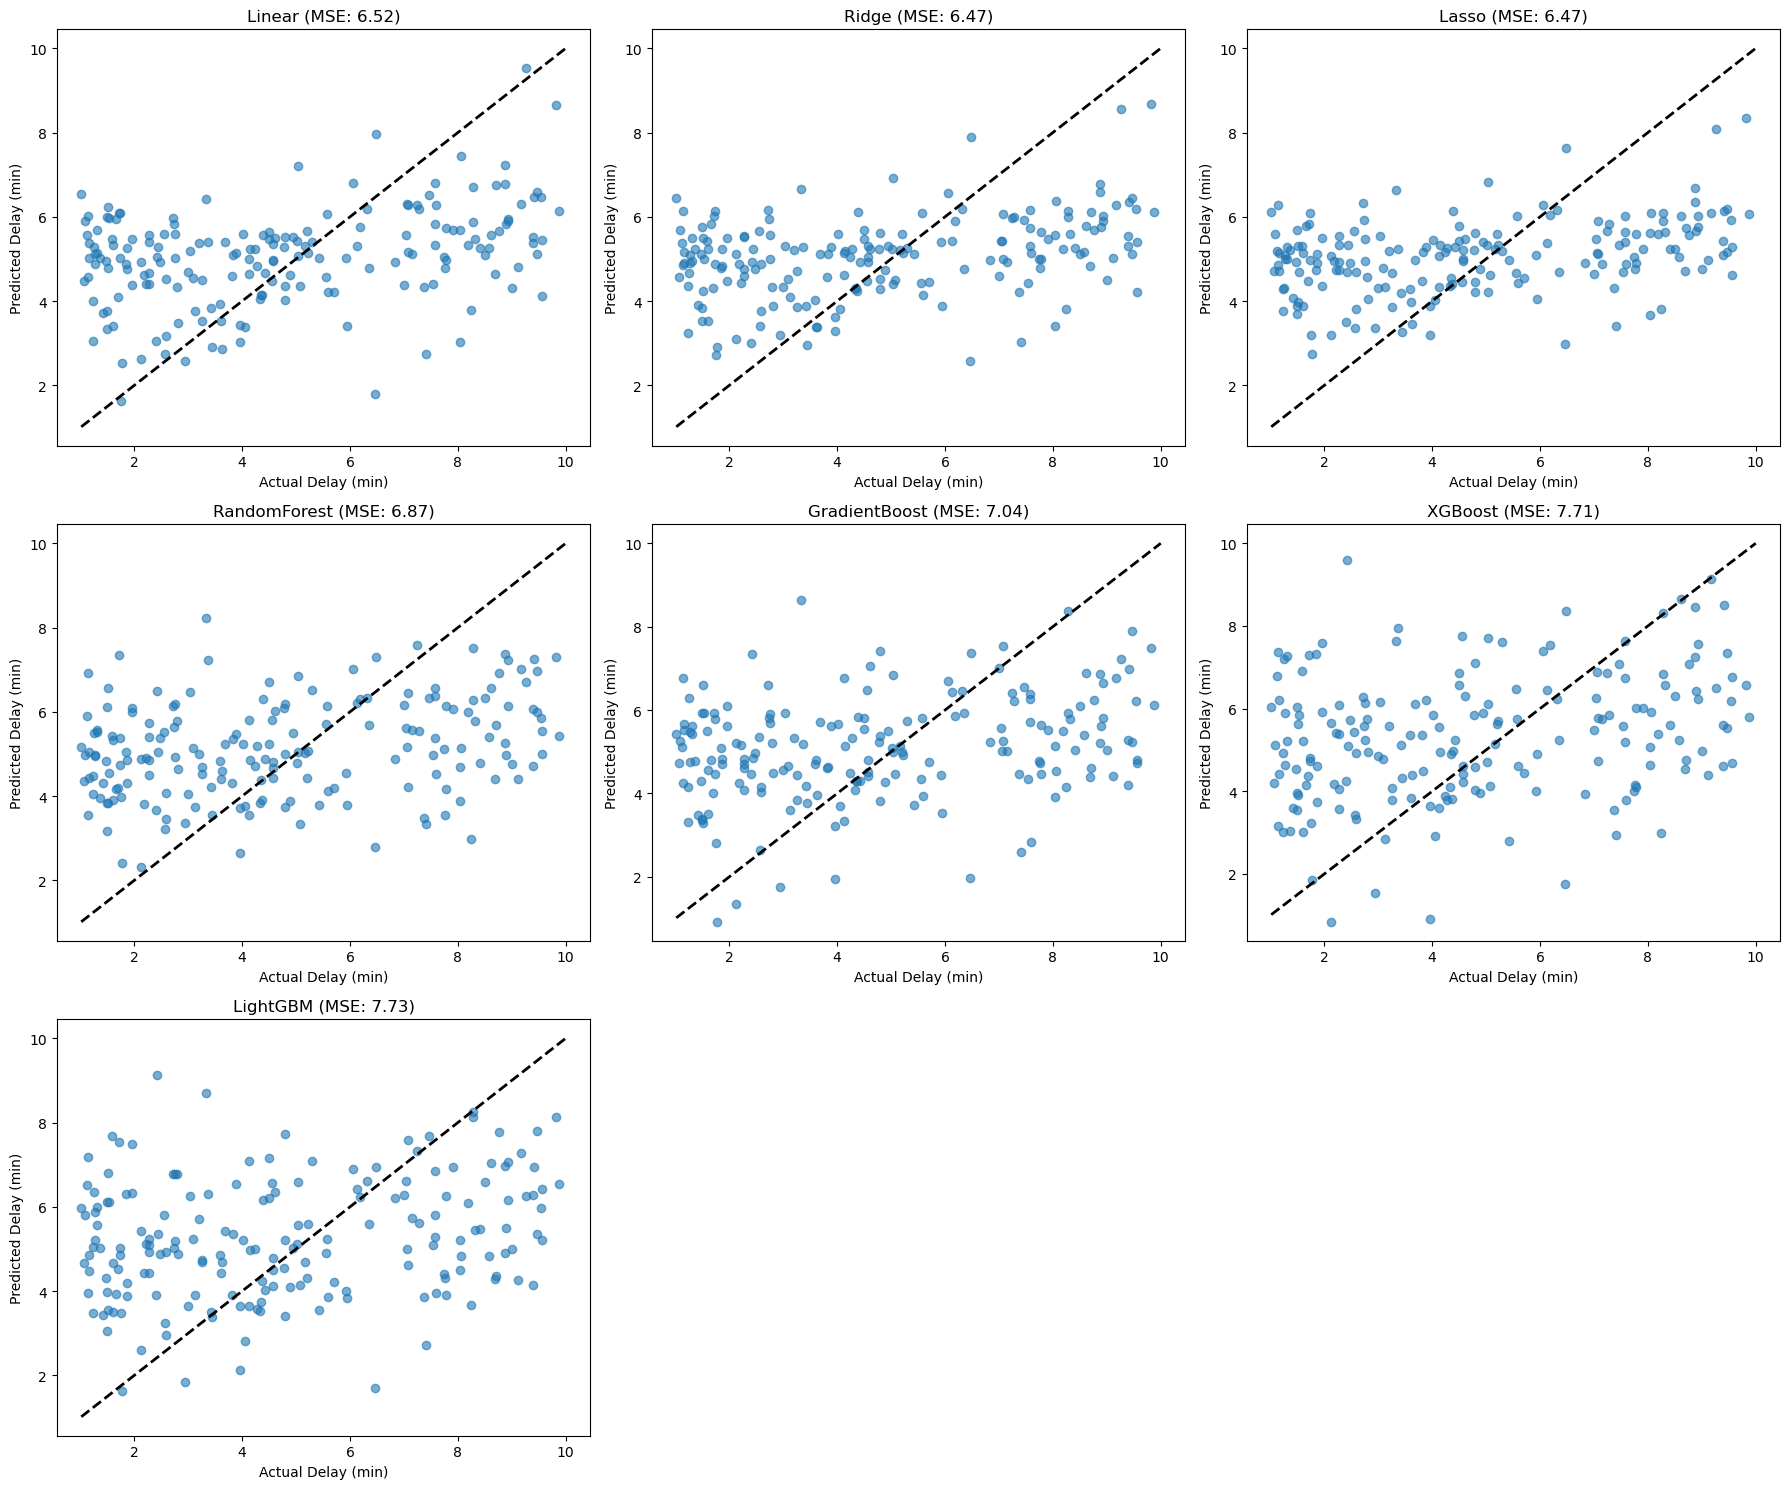

In [1000]:
train(features=features, scale_linear_models=True)

In [1001]:
df["hour_x_minutes_seen"] = df["hour"] * df["minutes_seen_before"]
df["opp_min_x_std"] = df["opp_min"] * df["opp_std"]
df["hour_x_direction"] = df["hour"] * df["direction_Linden"]


In [1002]:
features.append("hour_x_minutes_seen")
features.append("opp_min_x_std")
features.append("hour_x_direction")

[]
Linear MSE: 6.51
Ridge MSE: 6.42
Lasso MSE: 6.47
RandomForest MSE: 6.87
GradientBoost MSE: 7.05
XGBoost MSE: 7.85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2995
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 30
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.36

RandomForest Feature Importances:
 hourly_error_std         0.117834
minutes_seen_before      0.110139
opp_mean_diff            0.108557
hour_x_minutes_seen      0.091085
prev_error_times_seen    0.079012
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.119102
minutes_seen_before      0.116428
hour_x_minutes_seen      0.115094
hourly_error_std         0.106329
prev_error_times_seen    0.084338
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.122025
opp_mean_diff     

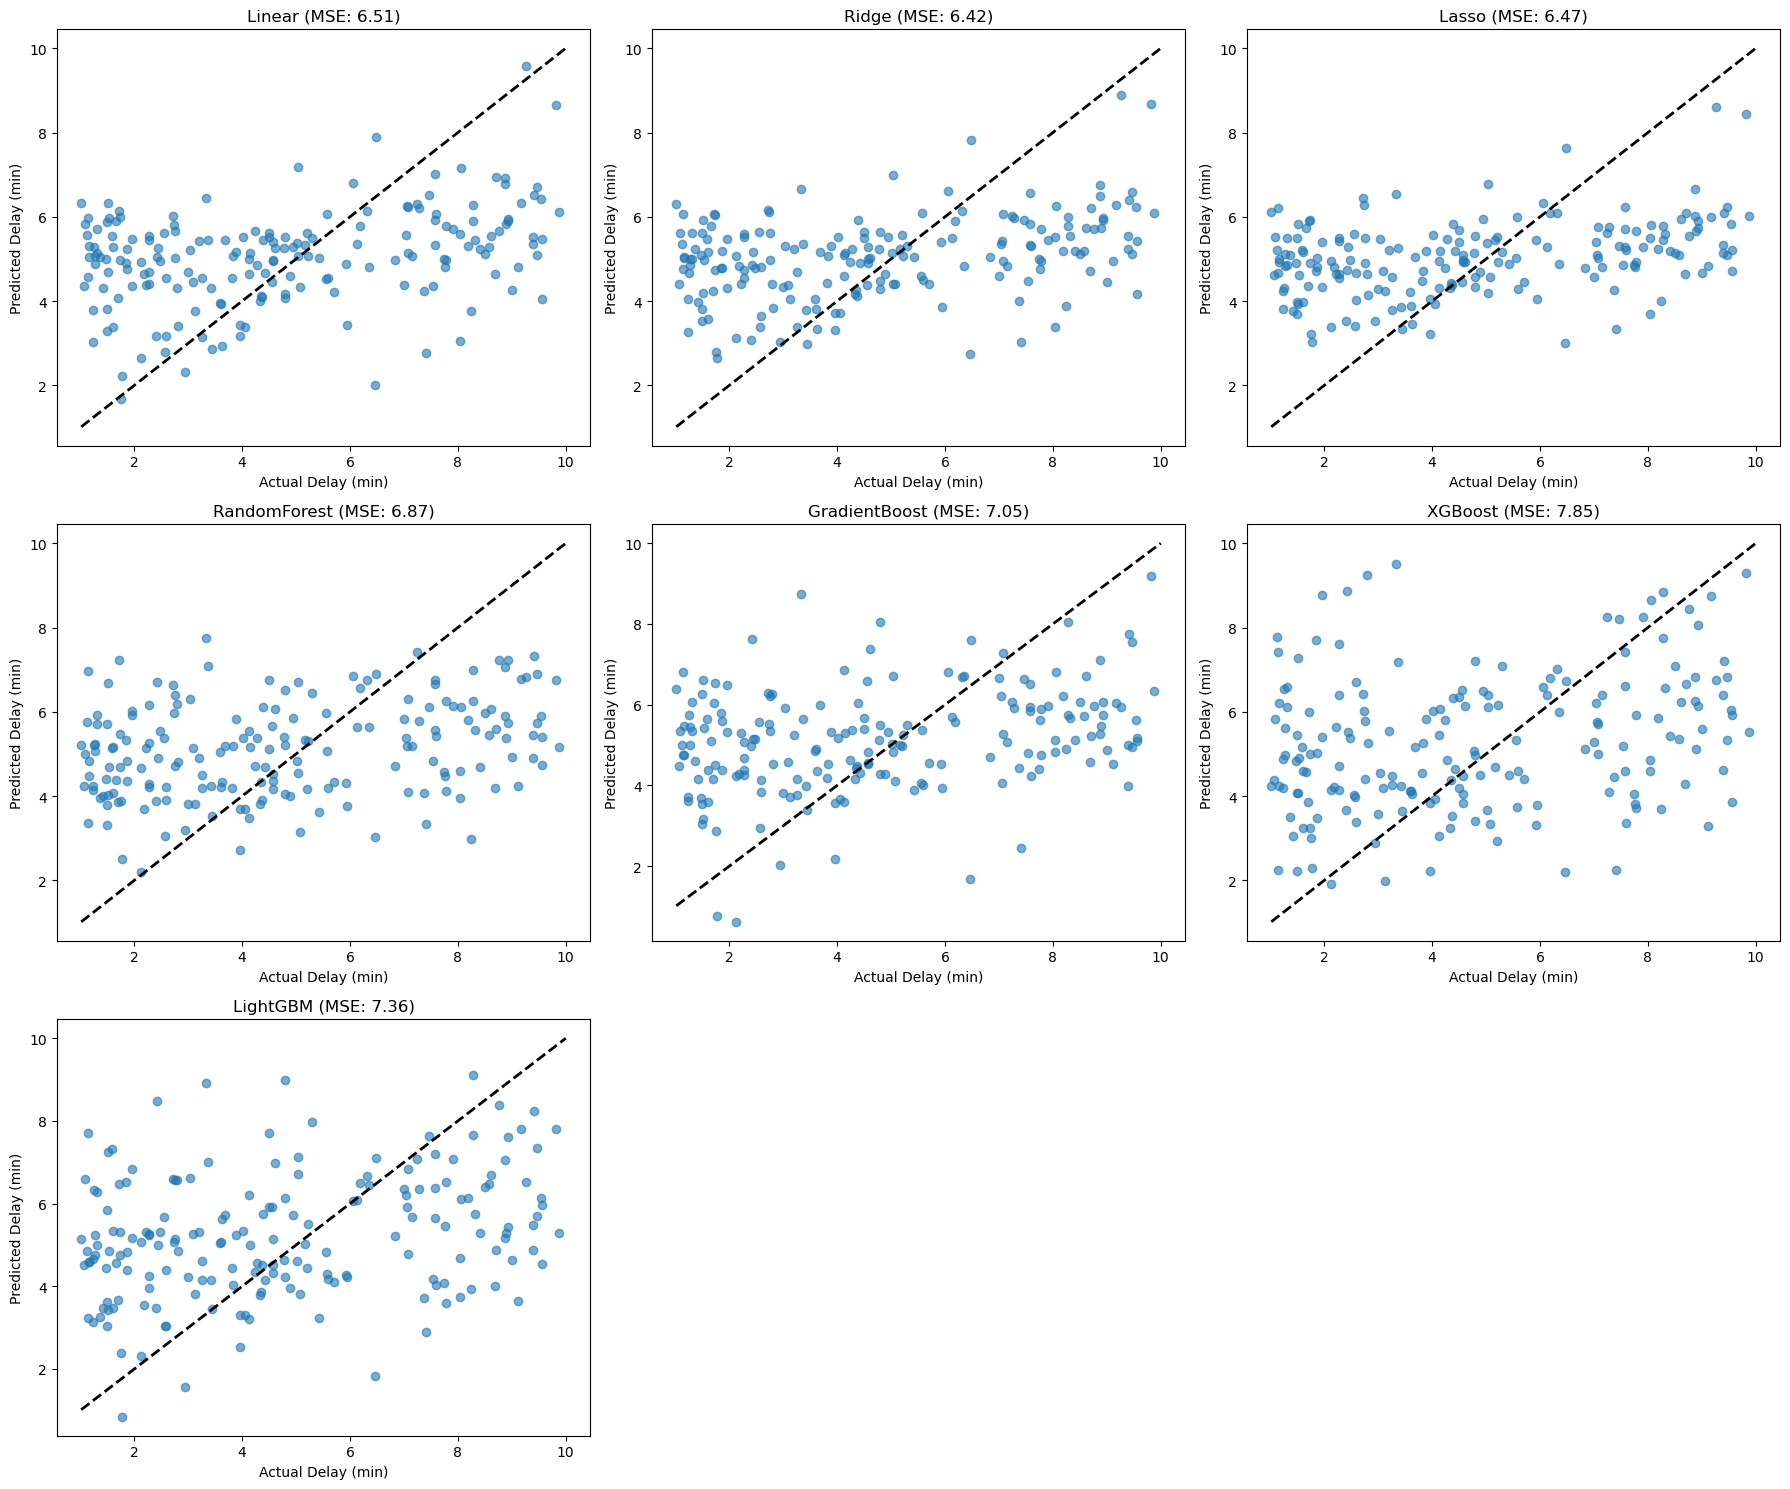

In [1003]:
train(features=features, scale_linear_models=True)

In [1004]:
window = "30min"
df.set_index("scheduled_arr", inplace=True)
df["trains_next_30min"] = (
    df.groupby("direction_Linden")["direction_Linden"]
        .transform(lambda x: x.rolling(window).count().shift(-1))
          .fillna(0)
)
df.reset_index(inplace=True)
features.append("trains_next_30min")


[]
Linear MSE: 6.51
Ridge MSE: 6.41
Lasso MSE: 6.47
RandomForest MSE: 6.80
GradientBoost MSE: 7.12
XGBoost MSE: 7.84
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 31
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.51

RandomForest Feature Importances:
 hourly_error_std         0.117339
opp_mean_diff            0.109458
minutes_seen_before      0.108846
hour_x_minutes_seen      0.091666
prev_error_times_seen    0.079983
dtype: float64

GradientBoost Feature Importances:
 minutes_seen_before      0.122077
opp_mean_diff            0.119661
hour_x_minutes_seen      0.115801
hourly_error_std         0.103757
prev_error_times_seen    0.086743
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.137199
opp_mean_diff     

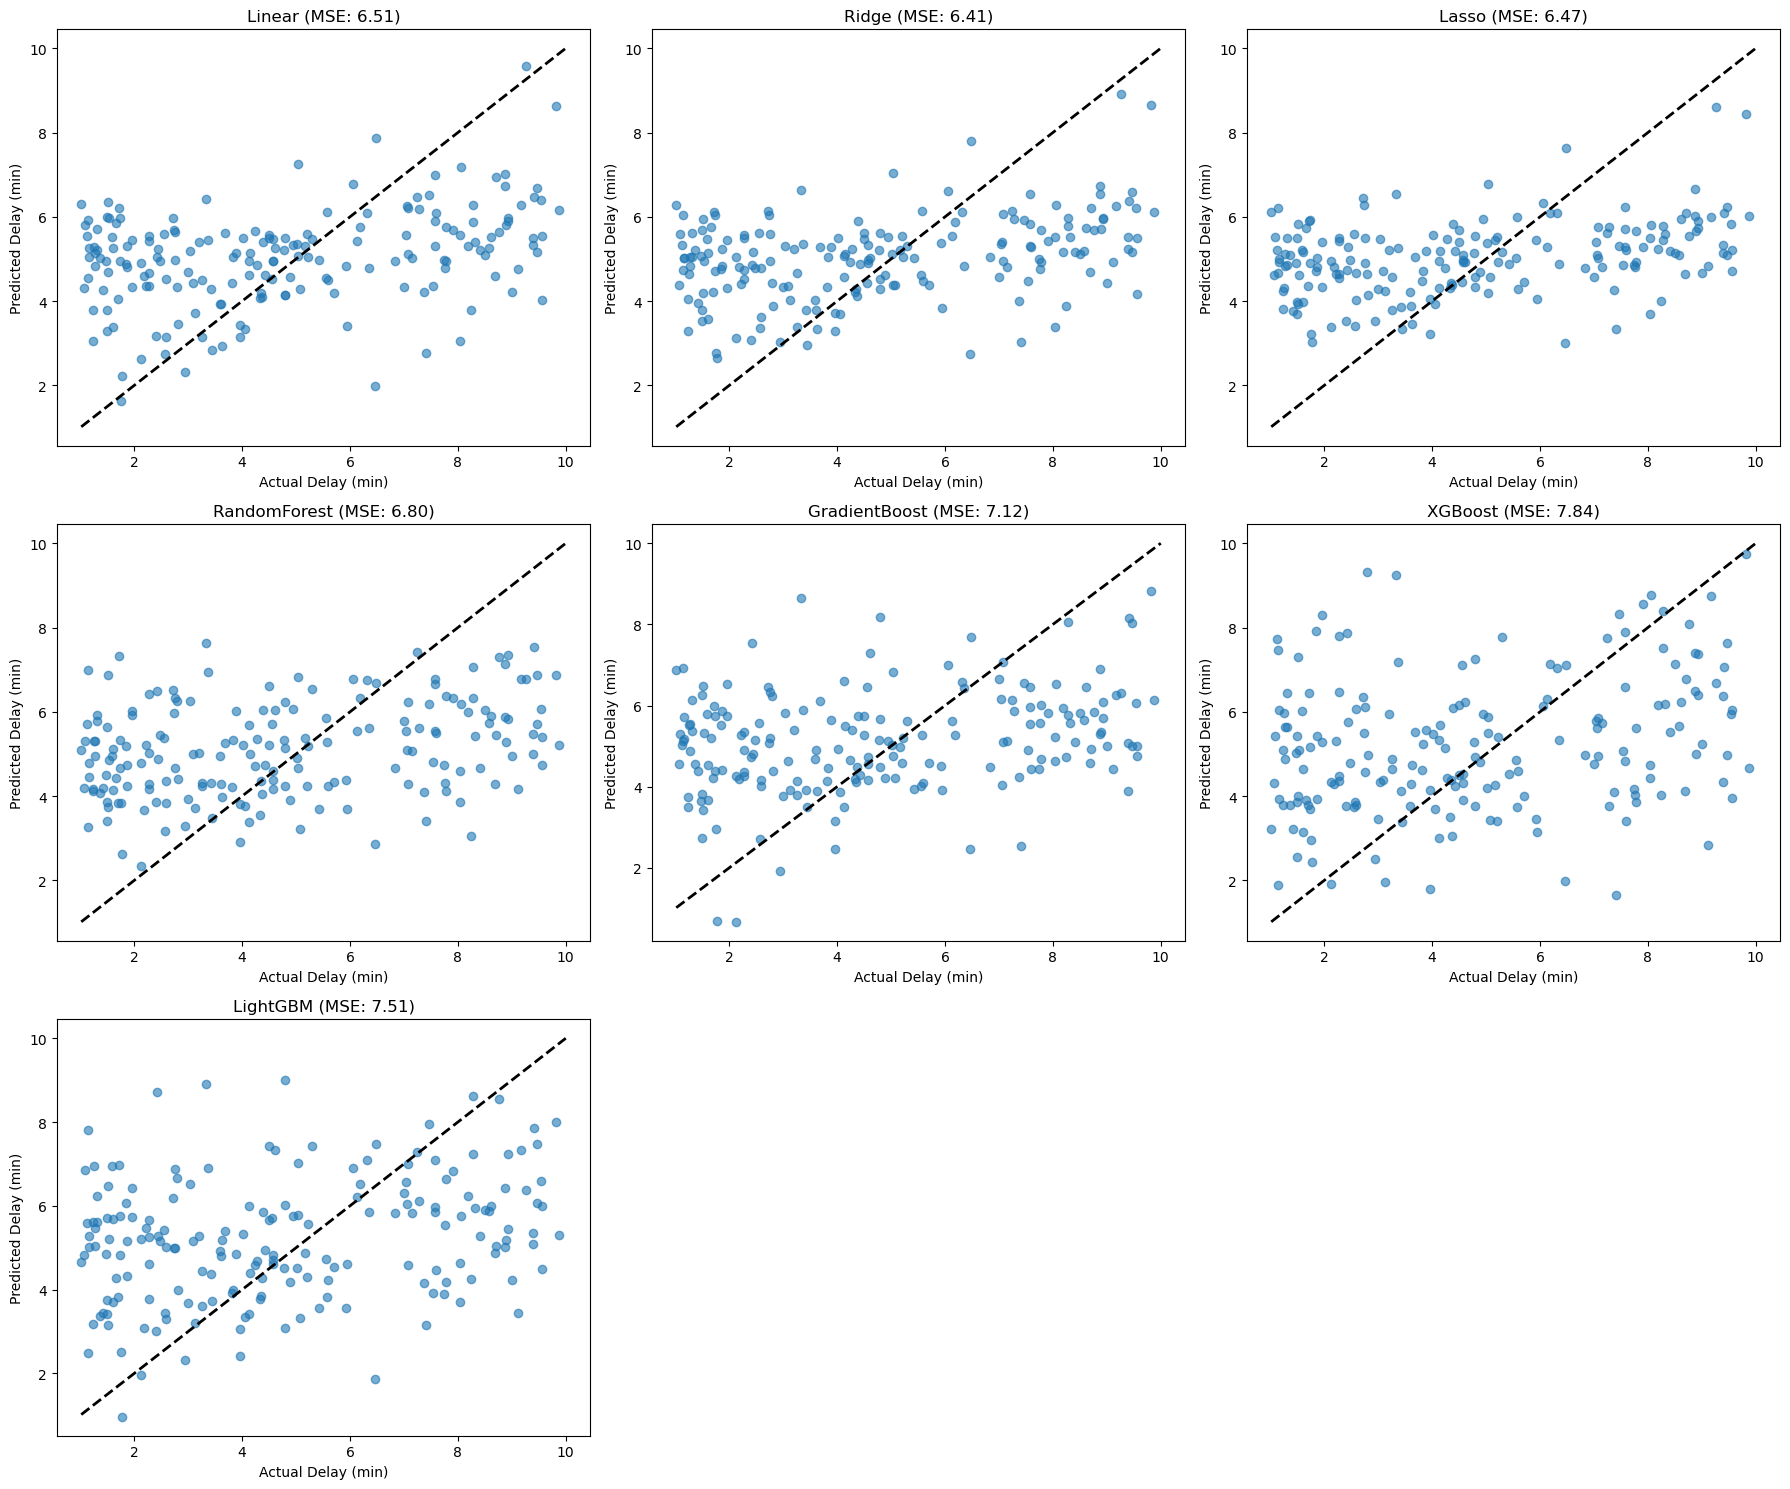

In [1005]:
train(features=features, scale_linear_models=True)

In [1006]:
df["prev_error_min"]   = df.groupby("direction_Linden")["error_min"].shift(1).fillna(0)
df["prev_error_min_2"] = df.groupby("direction_Linden")["error_min"].shift(2).fillna(0)
df["error_diff_1_2"]   = (df["prev_error_min"] - df["prev_error_min_2"]).fillna(0)


In [1007]:
features.append("prev_error_min")
features.append("prev_error_min_2")
features.append("error_diff_1_2")

In [1008]:
# remove any dupes from features
features = list(set(features))

[]
Linear MSE: 6.49
Ridge MSE: 6.39
Lasso MSE: 6.46
RandomForest MSE: 6.77
GradientBoost MSE: 7.21
XGBoost MSE: 7.52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3489
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 33
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.65

RandomForest Feature Importances:
 hourly_error_std         0.108740
minutes_seen_before      0.105130
opp_mean_diff            0.103612
hour_x_minutes_seen      0.085969
prev_error_times_seen    0.071020
dtype: float64

GradientBoost Feature Importances:
 hour_x_minutes_seen      0.111309
opp_mean_diff            0.111291
hourly_error_std         0.108220
minutes_seen_before      0.107915
prev_error_times_seen    0.079446
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.109264
opp_mean_diff     

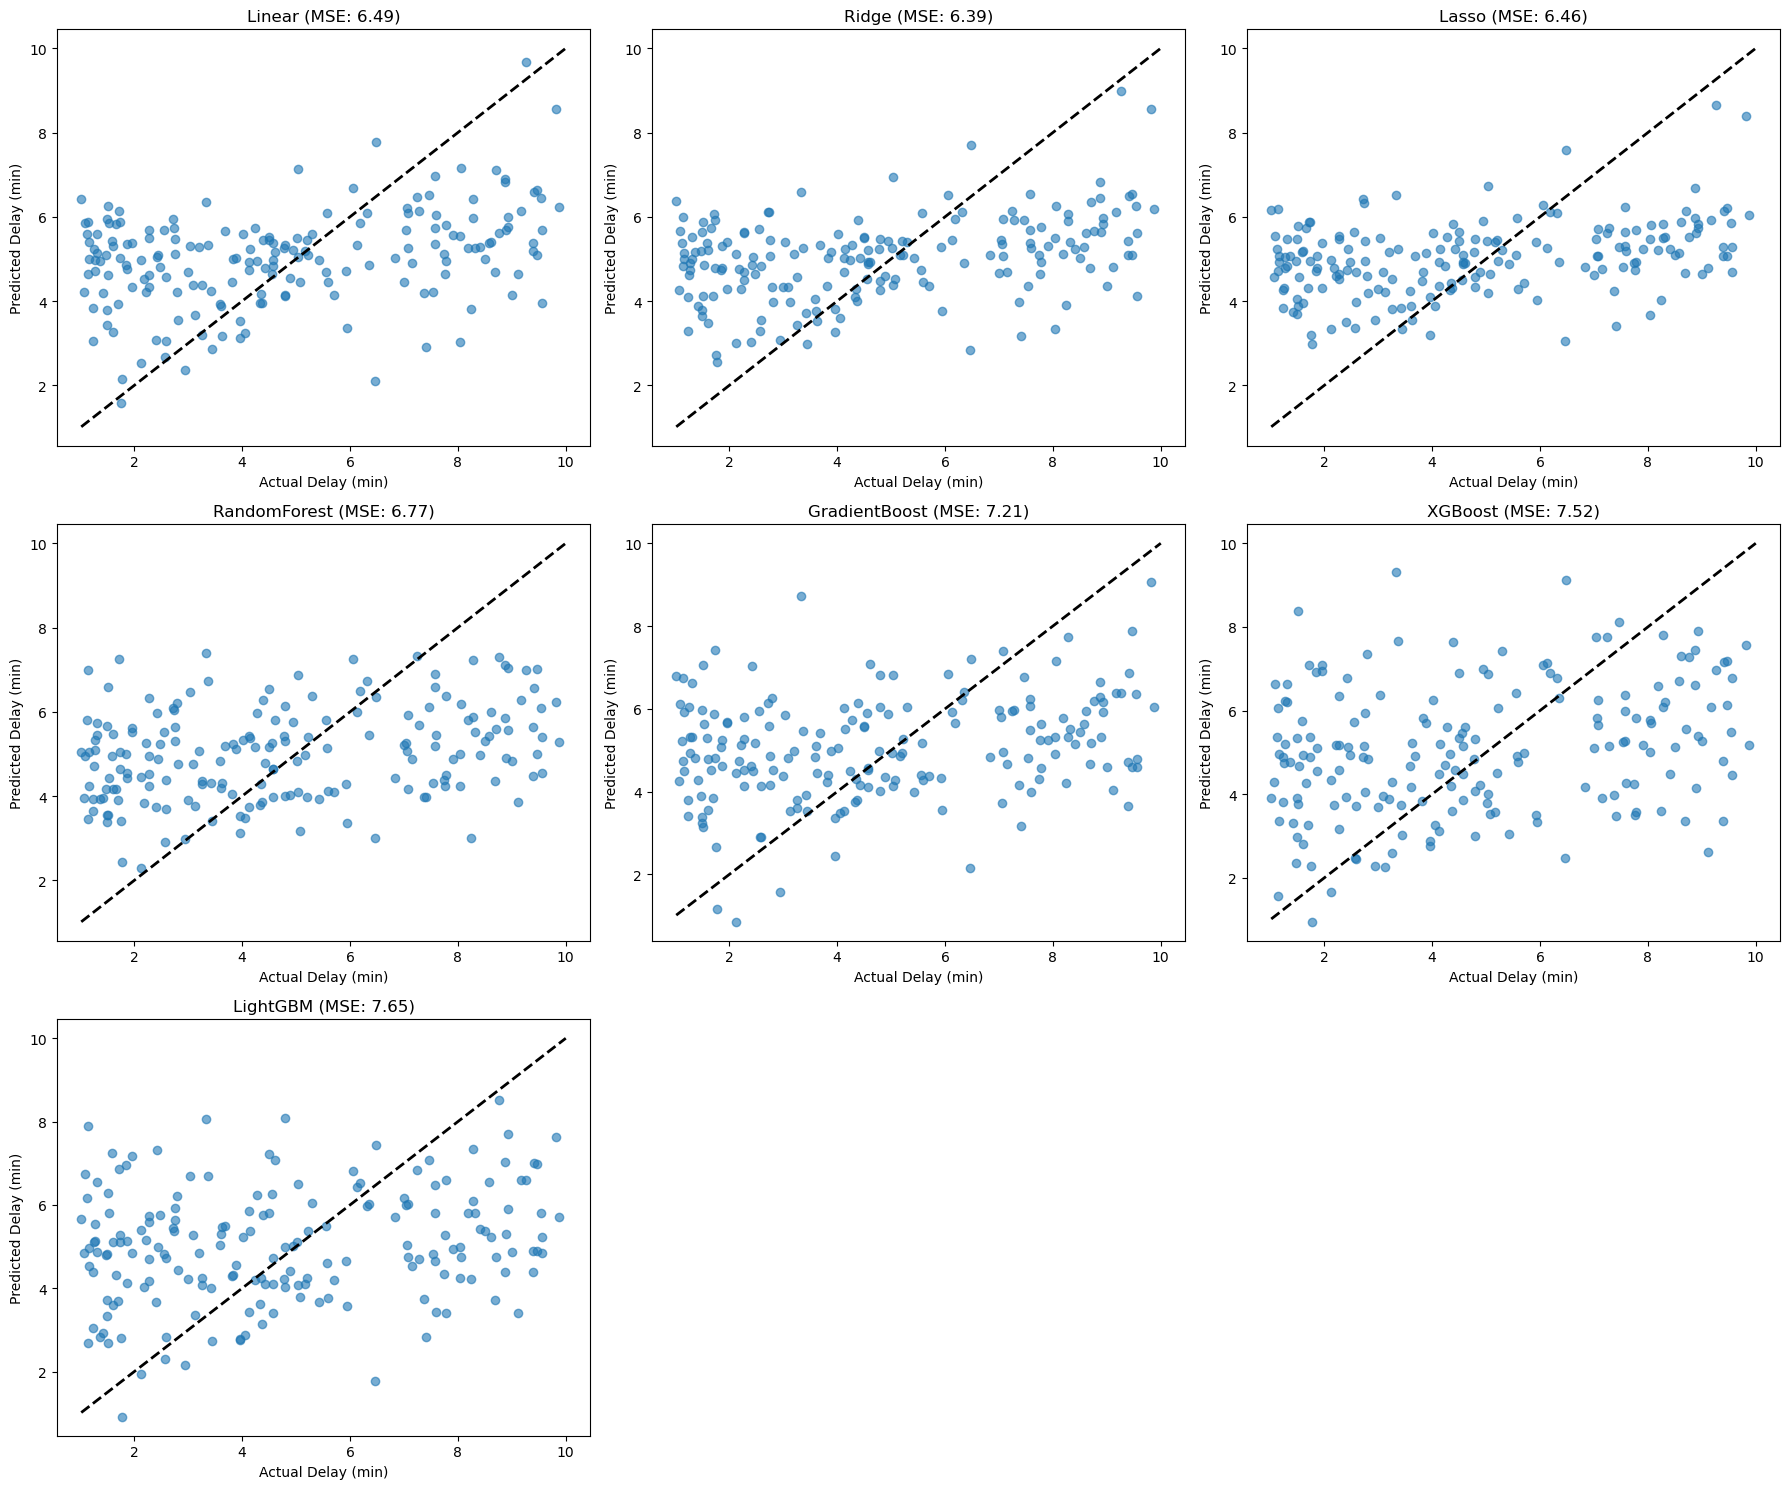

In [1009]:
train(features=features, scale_linear_models=True)

In [1010]:
df["hour_is_weekend"] = df["hour"] * df["is_weekend"]
df["hour_dayofweek"] = df["hour"] * df["dayofweek"]
df["hour_direction_Linden"] = df["hour"] * df["direction_Linden"]

features.extend(["hour_is_weekend", "hour_dayofweek", "hour_direction_Linden"])


[]
Linear MSE: 6.53
Ridge MSE: 6.39
Lasso MSE: 6.49
RandomForest MSE: 6.84
GradientBoost MSE: 6.98
XGBoost MSE: 7.39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3571
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 36
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.36

RandomForest Feature Importances:
 hourly_error_std         0.109152
minutes_seen_before      0.103557
opp_mean_diff            0.102910
hour_x_minutes_seen      0.083640
prev_error_times_seen    0.070682
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.116481
hour_x_minutes_seen      0.110849
minutes_seen_before      0.107958
hourly_error_std         0.103248
prev_error_times_seen    0.079928
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.149198
opp_mean_diff     

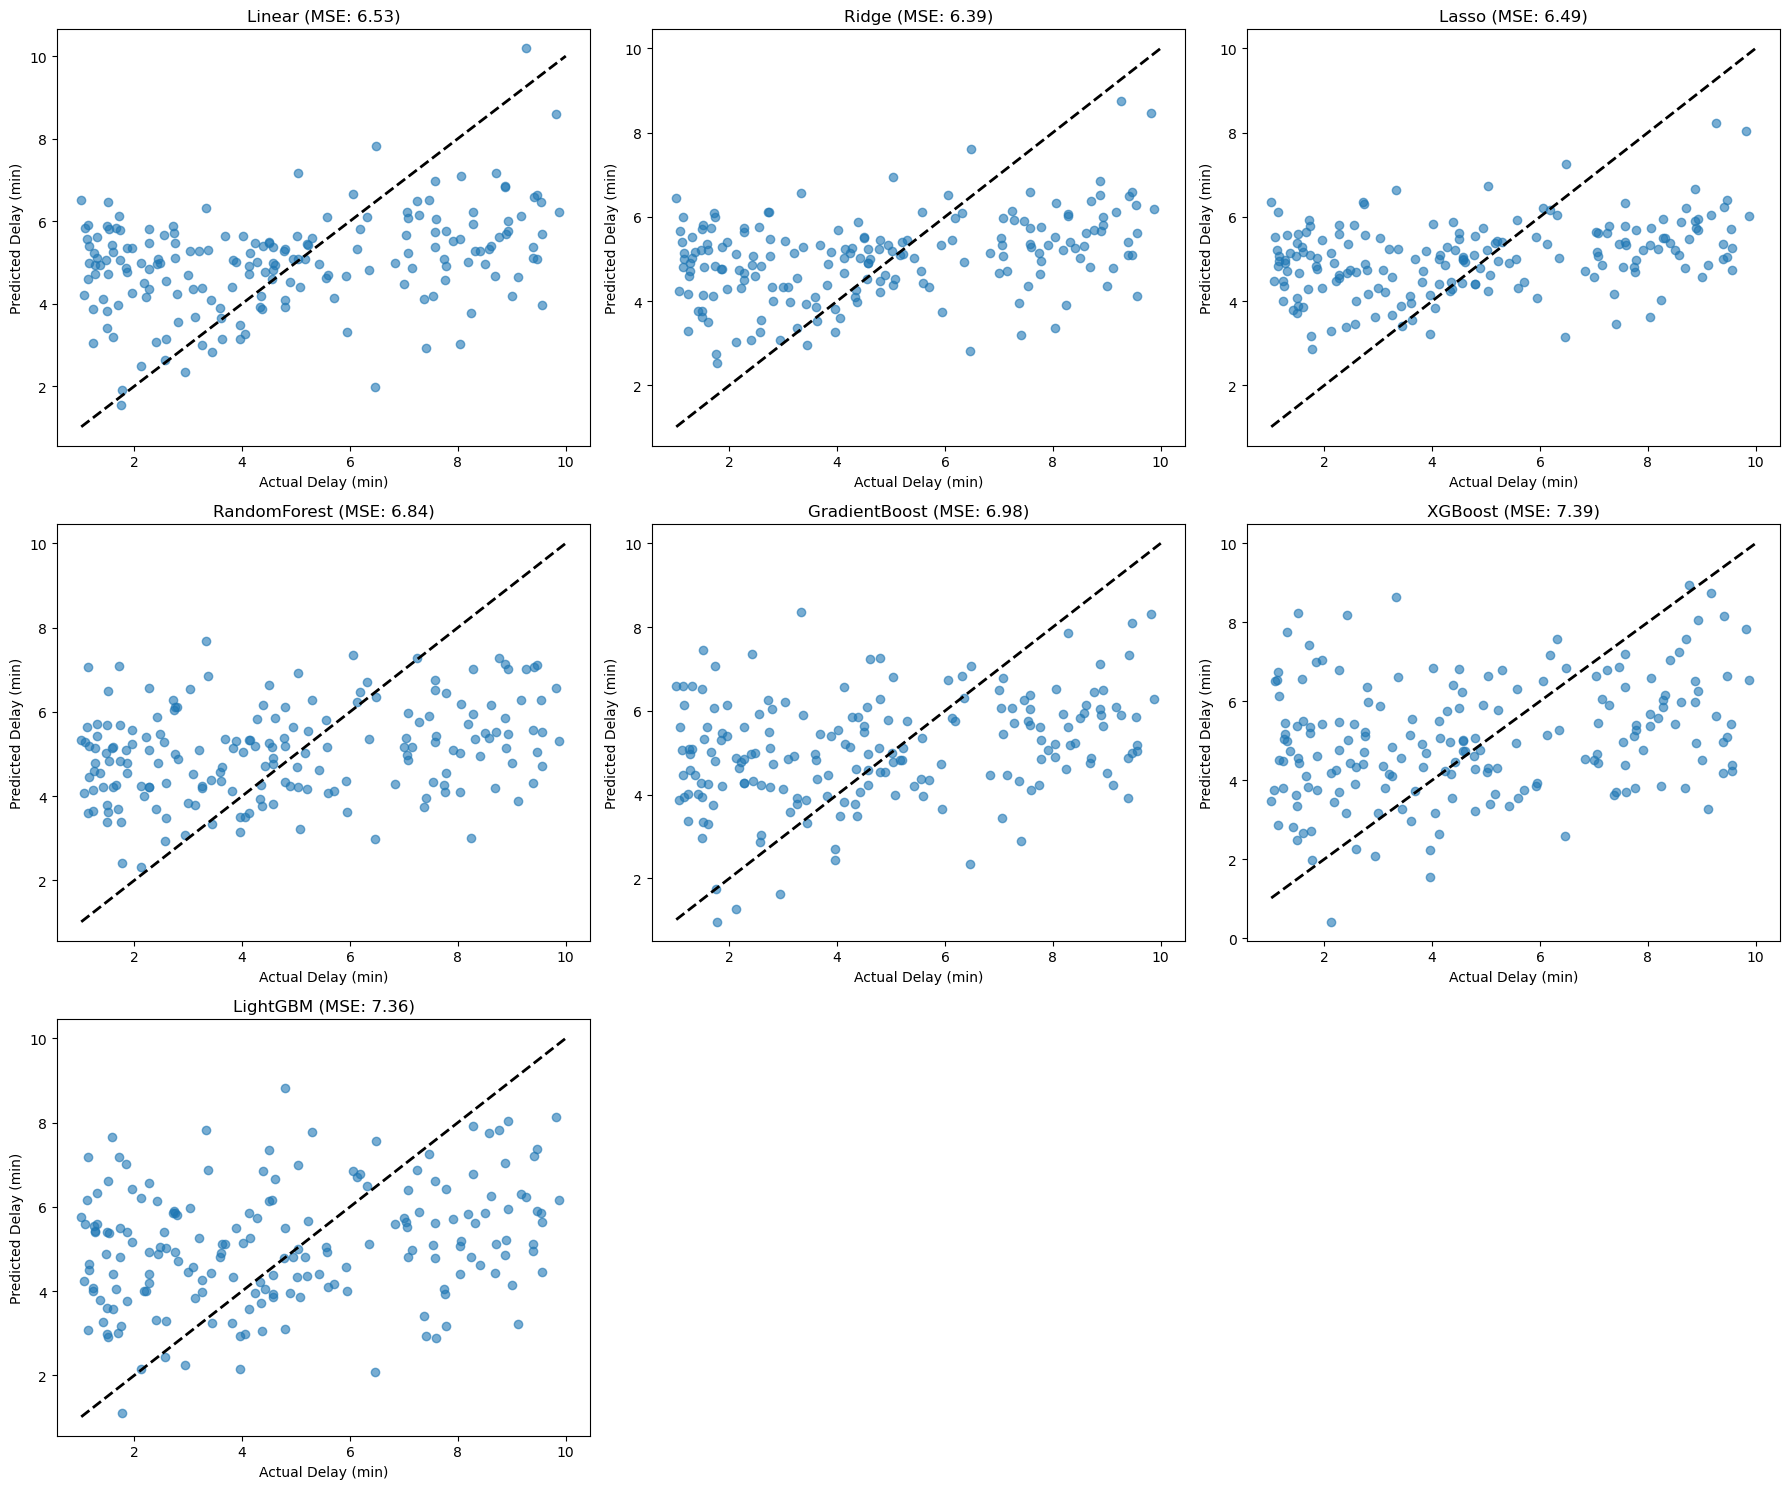

In [1011]:
train(features=features, scale_linear_models=True)

In [1012]:
df["is_holiday"] = df["scheduled_arr"].dt.strftime("%m-%d").isin([
    "01-01", "07-04", "12-25", "06-19" # Add more as needed
]).astype(int)
df["month"] = df["scheduled_arr"].dt.month
features.extend(["is_holiday"])

[]
Linear MSE: 6.53
Ridge MSE: 6.39
Lasso MSE: 6.49
RandomForest MSE: 6.86
GradientBoost MSE: 7.01
XGBoost MSE: 7.39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 37
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.36

RandomForest Feature Importances:
 hourly_error_std         0.109566
minutes_seen_before      0.103910
opp_mean_diff            0.103505
hour_x_minutes_seen      0.083165
prev_error_times_seen    0.071382
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff            0.116394
hour_x_minutes_seen      0.112295
minutes_seen_before      0.110001
hourly_error_std         0.100724
prev_error_times_seen    0.079979
dtype: float64

XGBoost Feature Importances:
 dir_error_trend        0.149198
opp_mean_diff     

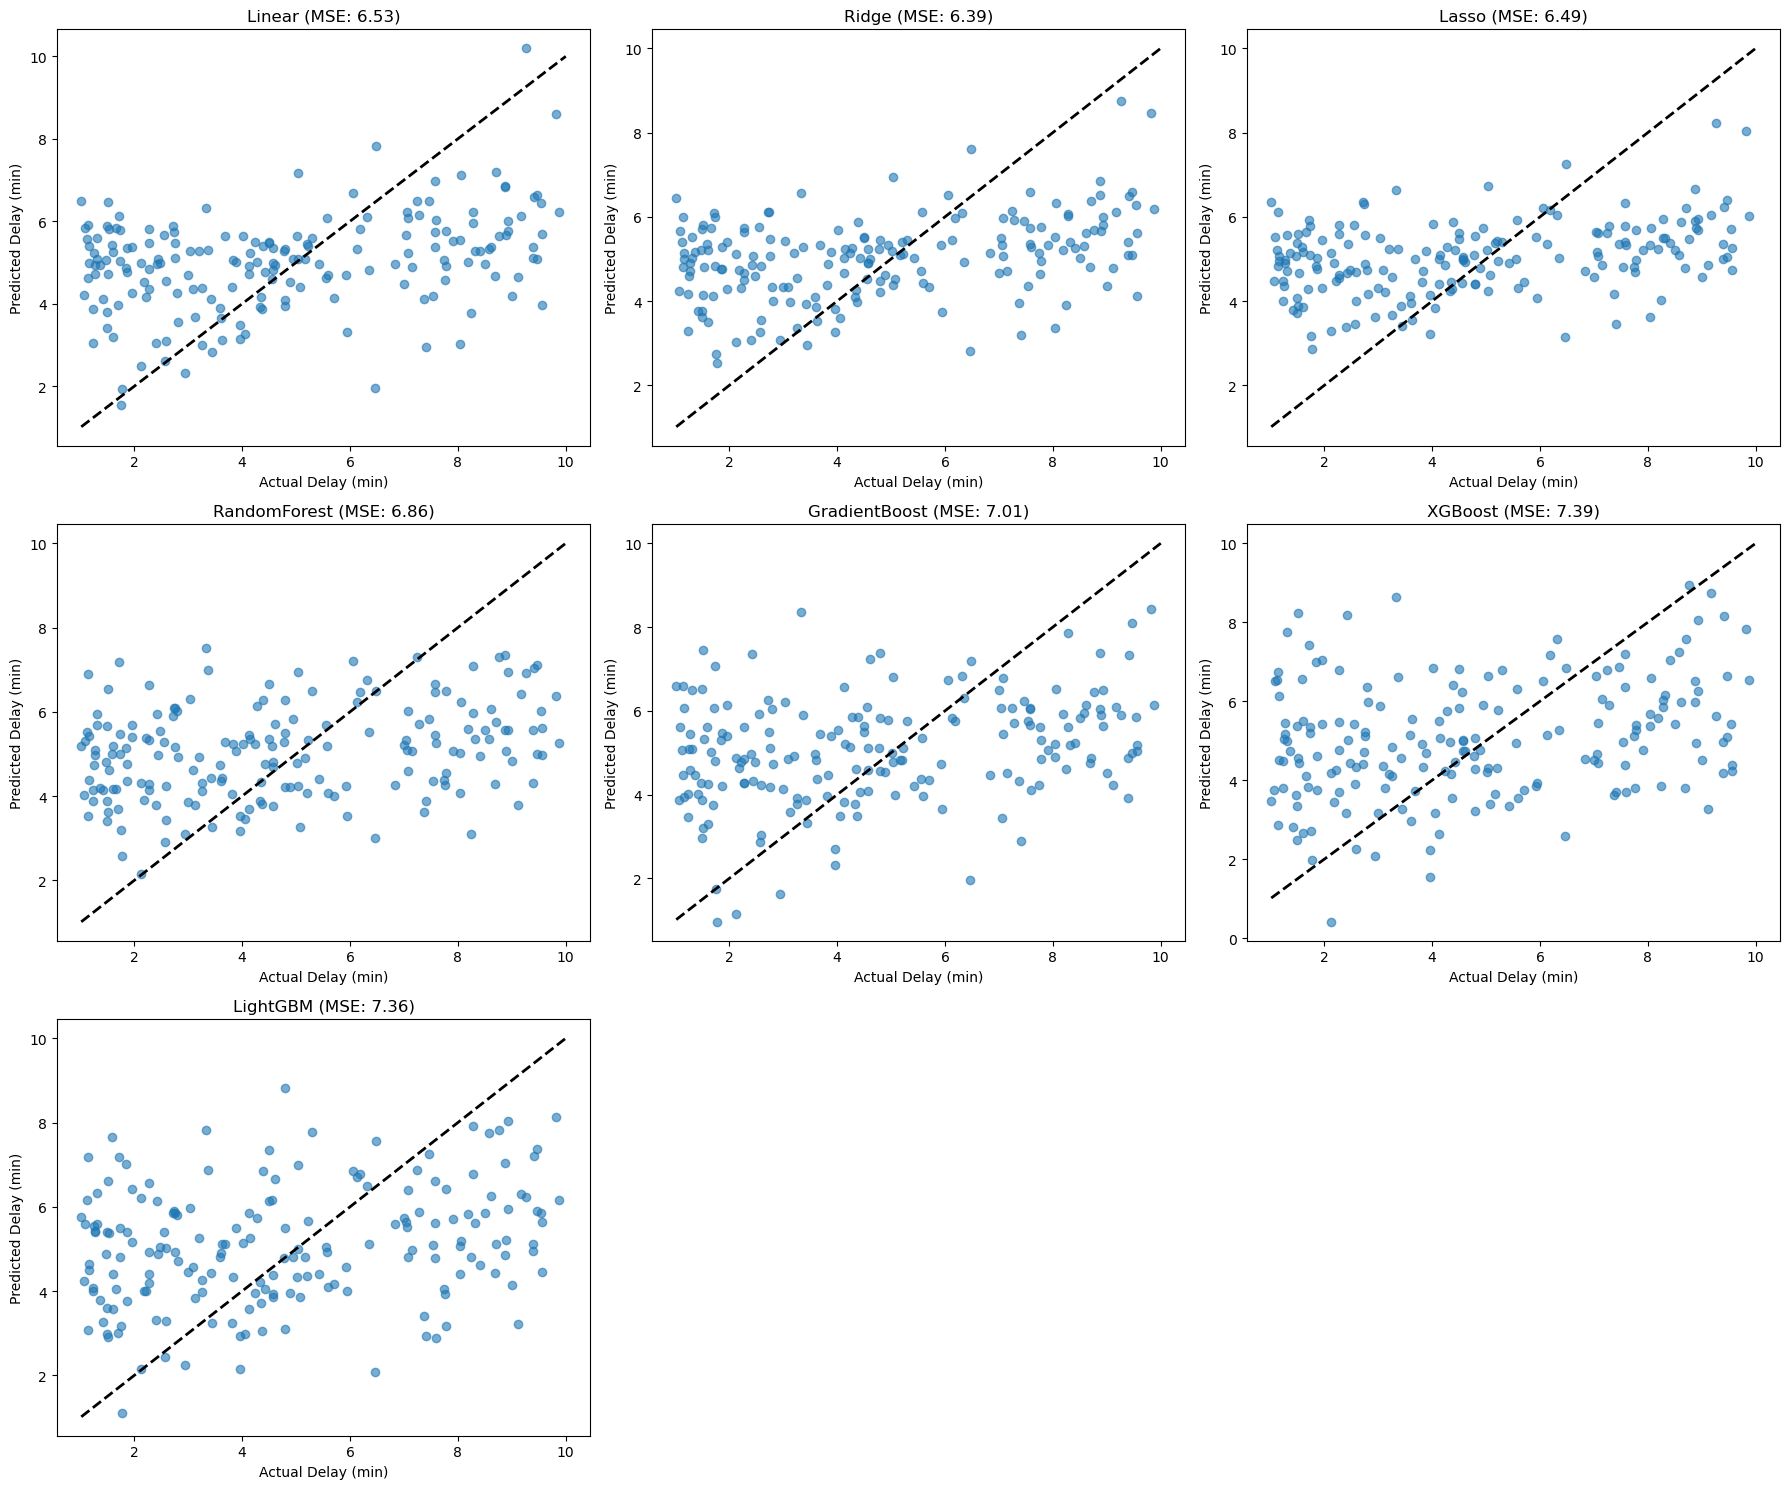

In [1013]:
train(features=features, scale_linear_models=True)

In [1014]:
def add_oof_residuals(df, features, target="error_min", n_splits=5):
    """
    Generate out-of-fold residuals for the entire DataFrame,
    then add them as a column 'residual_oof', without ever using
    a row’s own target to compute its residual.
    """
    df = df.sort_values("scheduled_arr").reset_index(drop=True)
    oof = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=False)  # no shuffle for time order

    for train_idx, valid_idx in kf.split(df):
        train_subset = df.iloc[train_idx]
        valid_subset = df.iloc[valid_idx]

        model = Ridge()
        model.fit(train_subset[features], train_subset[target])

        # Predict on the “valid” fold only
        preds = model.predict(valid_subset[features])
        oof[valid_idx] = valid_subset[target] - preds

    df["residual_oof"] = oof
    return df


In [1016]:

from sklearn.model_selection import TimeSeriesSplit

def time_series_cv_score(df, features, target="error_min", n_splits=5):
    features = list(set(features))  # Ensure no duplicates
    df = df.sort_values("scheduled_arr").reset_index(drop=True)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for train_idx, test_idx in tscv.split(df):
        train_set = df.iloc[train_idx]
        test_set  = df.iloc[test_idx]

        model = LGBMRegressor(n_estimators=100, random_state=42)
        model.fit(train_set[features], train_set[target])

        preds = model.predict(test_set[features])
        mse = mean_squared_error(test_set[target], preds)
        scores.append(mse)

    return scores

scores = time_series_cv_score(df, features)
print("CV MSEs:", scores, "Avg:", np.mean(scores))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 33
[LightGBM] [Info] Start training from score 5.019338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [1019]:
def cv_with_baseline_and_quantiles(
    df,
    raw_features,
    target="error_min",
    outer_splits=5,
    inner_splits=3,
    second_stage_model=None
):
    """
    1.  Sort df by 'scheduled_arr', then perform an outer TimeSeriesSplit.
    2.  For each outer fold:
         a) Split into train_full_df / test_df.
         b) On train_full_df ONLY, run an inner TimeSeriesSplit to fit a simple baseline (Ridge) 
            and compute “residual_baseline” for every training row (train_full_df).
         c) Fit the same baseline on ALL of train_full_df and compute “residual_baseline” for test_df.
         d) Now train “second_stage_model” on (train_full_df[ raw_features + ['residual_baseline'] ], target).
         e) Predict on test_df[ raw_features + ['residual_baseline'] ] → compute MSE.
    3.  Then, in a second pass over the SAME outer folds, train three separate GradientBoostingRegressor
        (loss="quantile", alpha=0.1/0.5/0.9) on each train_full portion (no stacking/residual in this block),
        predict on its test_df, and report:
          – median (0.5) MSE,
          – average width of [0.9 – 0.1] predictions on test_df.
    4.  Return two DataFrames: (A) baseline+second‐stage results, (B) quantile‐fold results.
    """

    # 1) Sort by time
    df = df.sort_values("scheduled_arr").reset_index(drop=True)
    n = len(df)
    outer_tscv = TimeSeriesSplit(n_splits=outer_splits)

    # Prepare result placeholders
    baseline_results = []
    quantile_results = []

    # ────────────────────────────────────────────────────────────────────────────
    # PART A: “Baseline‐Residual + Second‐Stage” fold loop
    # ────────────────────────────────────────────────────────────────────────────
    fold = 0
    for train_full_idx, test_idx in outer_tscv.split(df):
        # a) Isolate outer train_full / test
        train_full = df.iloc[train_full_idx].copy().reset_index(drop=True)
        test      = df.iloc[test_idx].copy().reset_index(drop=True)

        # b) Inside train_full, run inner TimeSeriesSplit to get residual_baseline for each training row
        train_full["residual_baseline"] = 0.0
        inner_tscv = TimeSeriesSplit(n_splits=inner_splits)

        for inner_train_idx, inner_valid_idx in inner_tscv.split(train_full):
            # Fit the baseline on inner‐train portion
            X_inner_tr = train_full.loc[inner_train_idx, raw_features]
            y_inner_tr = train_full.loc[inner_train_idx, target]

            baseline = Ridge()
            baseline.fit(X_inner_tr, y_inner_tr)

            # Predict on inner‐valid and store residuals
            X_inner_val = train_full.loc[inner_valid_idx, raw_features]
            y_inner_val = train_full.loc[inner_valid_idx, target]

            preds_val = baseline.predict(X_inner_val)
            train_full.loc[inner_valid_idx, "residual_baseline"] = (y_inner_val - preds_val)

        # c) Fit baseline on ALL of train_full, then predict on test set to get test residuals
        final_baseline = Ridge()
        final_baseline.fit(train_full[raw_features], train_full[target])

        #  ──> For training rows that never appeared in any inner‐valid (rare if inner_splits is small), fillna=0
        train_full["residual_baseline"].fillna(0.0, inplace=True)

        #  ──> Now compute test_df residuals:
        X_test_for_resid = test[raw_features]
        y_test_for_resid = test[target]
        preds_test_resid = final_baseline.predict(X_test_for_resid)
        test["residual_baseline"] = (y_test_for_resid - preds_test_resid)

        # d) Train second‐stage model on train_full[ raw_features + "residual_baseline" ]
        train_cols_ss = raw_features + ["residual_baseline"]
        X_train_ss = train_full[train_cols_ss]
        y_train_ss = train_full[target]

        if second_stage_model is None:
            second_stage_model = RandomForestRegressor(n_estimators=100, random_state=42)

        # Clone a fresh instance for each fold
        model_ss = second_stage_model.__class__(**second_stage_model.get_params())
        model_ss.fit(X_train_ss, y_train_ss)

        # e) Predict on test_df with that “residual_baseline” included
        X_test_ss = test[train_cols_ss]
        y_test_ss = test[target]
        y_pred_ss = model_ss.predict(X_test_ss)

        mse_fold = mean_squared_error(y_test_ss, y_pred_ss)
        baseline_results.append({
            "fold": fold,
            "train_size": len(train_full),
            "test_size": len(test),
            "mse_baseline_ss": mse_fold
        })

        print(f"Fold {fold} (Baseline+2ndStage):  train={len(train_full)}, test={len(test)},  MSE={mse_fold:.3f}")
        fold += 1

    df_baseline_results = pd.DataFrame(baseline_results)


    # ────────────────────────────────────────────────────────────────────────────
    # PART B: “Quantile‐Loss” fold loop
    # ────────────────────────────────────────────────────────────────────────────
    fold = 0
    for train_idx, test_idx in outer_tscv.split(df):
        train = df.iloc[train_idx].copy().reset_index(drop=True)
        test  = df.iloc[test_idx].copy().reset_index(drop=True)

        # We will train three separate QuantileGBRs on (train, target) and predict on test
        preds_q = {}
        for q in [0.1, 0.5, 0.9]:
            q_model = GradientBoostingRegressor(
                loss="quantile",
                alpha=q,
                learning_rate=0.05,
                n_estimators=200,
                max_depth=3,
                random_state=42
            )
            q_model.fit(train[raw_features], train[target])
            preds_q[q] = q_model.predict(test[raw_features])

        # Compute median‐MSE and average interval width
        mse_median = mean_squared_error(test[target], preds_q[0.5])
        avg_interval_width = np.mean(preds_q[0.9] - preds_q[0.1])

        quantile_results.append({
            "fold": fold,
            "train_size": len(train),
            "test_size": len(test),
            "mse_median": mse_median,
            "avg_0.9_minus_0.1": avg_interval_width
        })
        print(f"Fold {fold} (Quantile):  train={len(train)}, test={len(test)},  MAE(0.5)MSE={mse_median:.3f},  avgWidth={avg_interval_width:.2f}")
        fold += 1

    df_quantile_results = pd.DataFrame(quantile_results)

    return df_baseline_results, df_quantile_results


In [1029]:
# Get top features
# After your model is trained on full data:
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(df[features], df["error_min"])

# Get importances
importances = pd.Series(final_model.feature_importances_, index=features)
importances.sort_values(ascending=False, inplace=True)
print(importances)

opp_mean_diff            0.136985
hourly_error_std         0.121855
minutes_seen_before      0.098214
hourly_error_trend       0.058341
prev_error_times_seen    0.055019
prev_error_min_2         0.054324
next_sched_gap           0.054109
dir_error_trend          0.051274
prev_scheduled_gap       0.050206
hour_x_minutes_seen      0.046835
error_diff_1_2           0.041731
prev_error_min           0.040584
delta_opp_min            0.027964
hour_dayofweek           0.025066
opp_min_times_hour       0.021484
error_trend_linden       0.015559
dayofweek                0.013006
hour_cos                 0.012747
opp_min                  0.010748
hour_sin                 0.010465
opp_mean                 0.008763
error_trend_howard       0.008365
opp_std                  0.005514
hour                     0.005434
opp_min_x_std            0.005007
opp_count                0.003857
hour_x_direction         0.003463
hour_direction_Linden    0.003391
hour_is_weekend          0.003049
trains_next_30

In [1030]:
top_features = importances.head(10).index.tolist()

In [1038]:
top_features

['opp_mean_diff',
 'hourly_error_std',
 'minutes_seen_before',
 'hourly_error_trend',
 'prev_error_times_seen',
 'prev_error_min_2',
 'next_sched_gap',
 'dir_error_trend',
 'prev_scheduled_gap',
 'hour_x_minutes_seen']

In [ ]:
baseline_df, quantile_df = cv_with_baseline_and_quantiles(
    df,
    raw_features=top_features,
    target="error_min",
    outer_splits=5,
    inner_splits=3,
    second_stage_model=RandomForestRegressor(n_estimators=100, random_state=42)
)

print("\n=== Baseline+2nd‐Stage Results (Top Features) ===")
print(baseline_df)
print("Average MSE (baseline+2nd‐stage):", baseline_df["mse_baseline_ss"].mean())

print("\n=== Quantile Results (Top Features) ===")
print(quantile_df)
print("Average median‐MSE:", quantile_df["mse_median"].mean())
print("Average (0.9−0.1) width:", quantile_df["avg_0.9_minus_0.1"].mean())


Fold 0 (Baseline+2ndStage):  train=156, test=153,  MSE=0.750
Fold 1 (Baseline+2ndStage):  train=309, test=153,  MSE=0.345
Fold 2 (Baseline+2ndStage):  train=462, test=153,  MSE=0.576
Fold 3 (Baseline+2ndStage):  train=615, test=153,  MSE=0.296
Fold 4 (Baseline+2ndStage):  train=768, test=153,  MSE=0.434
Fold 0 (Quantile):  train=156, test=153,  MAE(0.5)MSE=4.279,  avgWidth=4.39
Fold 1 (Quantile):  train=309, test=153,  MAE(0.5)MSE=4.500,  avgWidth=4.46
Fold 2 (Quantile):  train=462, test=153,  MAE(0.5)MSE=4.776,  avgWidth=4.71
Fold 3 (Quantile):  train=615, test=153,  MAE(0.5)MSE=5.176,  avgWidth=5.28
Fold 4 (Quantile):  train=768, test=153,  MAE(0.5)MSE=7.016,  avgWidth=5.49

=== Baseline+2nd‐Stage Results (Top Features) ===
   fold  train_size  test_size  mse_baseline_ss
0     0         156        153         0.750356
1     1         309        153         0.344624
2     2         462        153         0.575768
3     3         615        153         0.296123
4     4         768     

In [1032]:
holdout_size = 200  # or something like int(0.2 * len(df))

df_train = df.iloc[:-holdout_size].copy()
df_holdout = df.iloc[-holdout_size:].copy()

In [1035]:
# Predict on the holdout set
# Prepare holdout data
holdout_X = df_holdout[top_features]
holdout_y = df_holdout["error_min"]

# Train model on full training set using top features
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(df[top_features], df["error_min"])

# Predict on holdout
holdout_preds = final_model.predict(holdout_X)
holdout_mse = mean_squared_error(holdout_y, holdout_preds)

print("\n=== Holdout Set Evaluation (Top Features) ===")
print("Holdout MSE (baseline + 2nd-stage):", holdout_mse)



=== Holdout Set Evaluation (Top Features) ===
Holdout MSE (baseline + 2nd-stage): 0.8922077319444451


In [1037]:
# Pickle this model for later use   
with open("final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

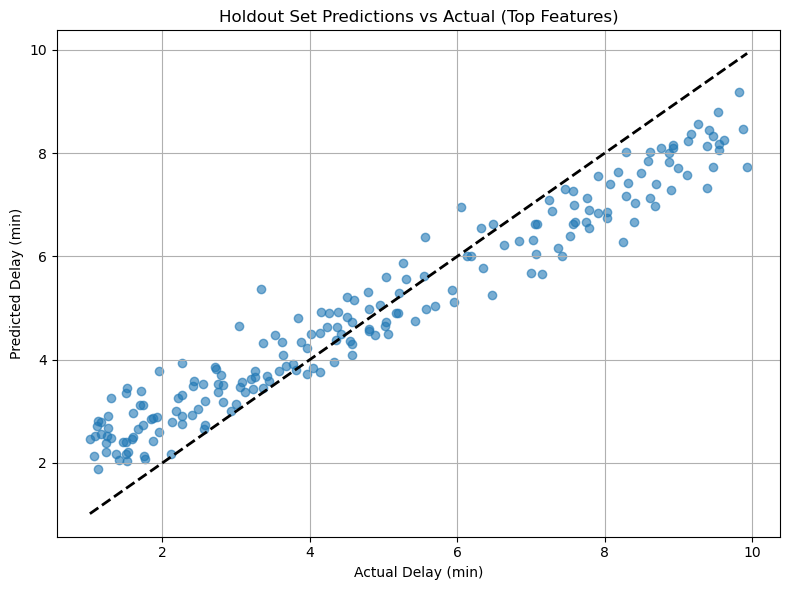

In [1036]:
# Plot holdout predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(holdout_y, holdout_preds, alpha=0.6)
plt.plot([holdout_y.min(), holdout_y.max()], [holdout_y.min(), holdout_y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Holdout Set Predictions vs Actual (Top Features)")
plt.grid(True)
plt.tight_layout()
plt.show()